# Do DL models and training environments have an impact on the energy consumption of computer vision training?

Author: Santiago del Rey

## Import libraries

In [1]:
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
from cliffs_delta import cliffs_delta
from scipy import stats

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.data.analysis import (
    test_assumptions,
    boxplot,
    barplot,
    eta_squared,
    is_pareto_efficient,
    print_improvement,
)
from src.environment import FIGURES_DIR, METRICS_DIR
from src.data.preprocessing import MJOULES_TO_JOULES, HOURS_TO_MILISECONDS, build_analysis_dataset, build_metrics_dataset


SAVE_FIGS = True
FIGURES_FORMAT = "png"

sns.set_theme(palette="colorblind", color_codes=True)

%matplotlib inline

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams["font.weight"] = "bold"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.autolayout"] = "true"
mpl.rcParams["axes.grid"] = "true"
mpl.rcParams["grid.color"] = "gray"

2023-12-21 13:30:50.487877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 13:30:50.895906: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 13:30:51.425010: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-21 13:30:51.425111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Load the dataset

In [2]:
# build_metrics_dataset(output_folder=os.path.join(METRICS_DIR, "interim"))
# build_analysis_dataset(output_folder=os.path.join(METRICS_DIR, "processed"))

/home/santiago/Projects/seaa2023_ect/src/data/preprocessing.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_metrics.loc[:, "metrics.MACCS"] = relevant_metrics["metrics.MACCS"].apply(
/home/santiago/Projects/seaa2023_ect/src/data/preprocessing.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_metrics.rename(
/home/santiago/Projects/seaa2023_ect/src/data/preprocessing.py:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

,training environment,architecture,run,training duration (h),gpu model,gpu working time (h),gpu usage (%),gpu memory working time (h),gpu memory usage,average memory used (MB),...,validation size,batch size,GFLOPs,accuracy,precision,recall,AUC,trained epochs,total seen images,f1-score
0,Cloud,mobilenet_v2,0,0.734750,NVIDIA GeForce RTX 3090,0.168889,23.004162,0.061686,0.084022,23648.749527,...,10203,32,0.064028,0.975629,0.959826,0.993169,0.995675,98,3327296,0.976213
1,Cloud,mobilenet_v2,1,0.795914,NVIDIA GeForce RTX 3090,0.182600,22.960531,0.066108,0.083126,23657.000000,...,10203,32,0.064028,0.971108,0.957560,0.986339,0.992465,102,3463104,0.971736
2,Cloud,mobilenet_v2,2,0.471948,NVIDIA GeForce RTX 3090,0.105261,22.316843,0.038169,0.080925,23657.000000,...,10203,32,0.064028,0.960397,0.956488,0.965262,0.987073,65,2206880,0.960855
3,Cloud,mobilenet_v2,3,0.634343,NVIDIA GeForce RTX 3090,0.144261,22.758107,0.052850,0.083374,23657.000000,...,10203,32,0.064028,0.974941,0.962921,0.988290,0.994777,84,2851968,0.975441
4,Cloud,mobilenet_v2,4,0.662703,NVIDIA GeForce RTX 3090,0.150069,22.661493,0.053986,0.081523,23657.000000,...,10203,32,0.064028,0.968553,0.957524,0.981070,0.990629,86,2919872,0.969154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,Local ML Engineer/Gamer,xception,25,0.777240,NVIDIA GeForce RTX 3070,0.719850,92.717710,0.460592,0.593249,7479.000000,...,10203,32,2.958404,0.981427,0.970627,0.993169,0.998007,71,2410592,0.981769
365,Local ML Engineer/Gamer,xception,26,0.735790,NVIDIA GeForce RTX 3070,0.681156,92.674225,0.436042,0.593254,7479.000000,...,10203,32,2.958404,0.980936,0.969882,0.992974,0.997877,68,2308736,0.981292
366,Local ML Engineer/Gamer,xception,27,0.918272,NVIDIA GeForce RTX 3070,0.852689,92.964264,0.543200,0.592223,7479.000000,...,10203,32,2.958404,0.982704,0.971777,0.994536,0.998162,81,2750112,0.983025
367,Local ML Engineer/Gamer,xception,28,1.099361,NVIDIA GeForce RTX 3070,1.023167,93.179863,0.650747,0.592636,7479.000000,...,10203,32,2.958404,0.984080,0.975834,0.992974,0.998493,94,3191488,0.984330


In [3]:
analysis_df = pd.read_parquet(os.path.join(METRICS_DIR, "processed", "dl-training-energy-consumption-dataset.gzip"))
print(analysis_df.shape)
analysis_df.head()

(369, 31)


,training environment,architecture,run,training duration (h),gpu model,gpu working time (h),gpu usage (%),gpu memory working time (h),gpu memory usage,average memory used (MB),...,validation size,batch size,GFLOPs,accuracy,precision,recall,AUC,trained epochs,total seen images,f1-score
0,Cloud,mobilenet_v2,0,0.734750,NVIDIA GeForce RTX 3090,0.168889,23.004162,0.061686,0.084022,23648.749527,...,10203,32,0.064028,0.975629,0.959826,0.993169,0.995675,98,3327296,0.976213
1,Cloud,mobilenet_v2,1,0.795914,NVIDIA GeForce RTX 3090,0.182600,22.960531,0.066108,0.083126,23657.000000,...,10203,32,0.064028,0.971108,0.957560,0.986339,0.992465,102,3463104,0.971736
2,Cloud,mobilenet_v2,2,0.471948,NVIDIA GeForce RTX 3090,0.105261,22.316843,0.038169,0.080925,23657.000000,...,10203,32,0.064028,0.960397,0.956488,0.965262,0.987073,65,2206880,0.960855
3,Cloud,mobilenet_v2,3,0.634343,NVIDIA GeForce RTX 3090,0.144261,22.758107,0.052850,0.083374,23657.000000,...,10203,32,0.064028,0.974941,0.962921,0.988290,0.994777,84,2851968,0.975441
4,Cloud,mobilenet_v2,4,0.662703,NVIDIA GeForce RTX 3090,0.150069,22.661493,0.053986,0.081523,23657.000000,...,10203,32,0.064028,0.968553,0.957524,0.981070,0.990629,86,2919872,0.969154


## Data analysis

In [4]:
TRAIN_STRATEGIES = ["Local N", "Local ML", "Cloud"]
MARKERS = {
    "MobileNet V2": "o",
    "NASNet Mobile": "v",
    "Xception": "^",
    "ResNet50": "X",
    "VGG16": "P",
}
COLORS = {"Local N": "b", "Local ML": "orange", "Cloud": "g"}
ARCHITECTURE_LABELS = ["MobileNet\nV2", "NASNet\nMobile", "ResNet50", "VGG16", "Xception"]

analysis_df.rename(
    columns={
        "energy (MJ)": "energy",
        "gpu usage (%)": "gpu_usage",
        "average temperature (Celsius)": "temperature",
        "emissions (tCO2e)": "emissions",
    },
    inplace=True,
)

analysis_df.replace(
    {
        "Local Normal User": "Local N",
        "Local ML Engineer/Gamer": "Local ML",
        "mobilenet_v2": "MobileNet V2",
        "nasnet_mobile": "NASNet Mobile",
        "xception": "Xception",
        "resnet50": "ResNet50",
        "vgg16": "VGG16",
    },
    inplace=True,
)

analysis_df["raw energy"] = analysis_df.energy.copy()
analysis_df["energy"] = analysis_df["raw energy"] * MJOULES_TO_JOULES / analysis_df["total seen images"]
analysis_df["normalized duration"] = (
    analysis_df["training duration (h)"] * HOURS_TO_MILISECONDS / analysis_df["total seen images"]
)

In [5]:
local_n_mobilenet = analysis_df.query("`training environment` == 'Local N' & architecture == 'MobileNet V2'")
local_n_nasnet = analysis_df.query("`training environment` == 'Local N' & architecture == 'NASNet Mobile'")

local_ml_mobilenet = analysis_df.query("`training environment` == 'Local ML' & architecture == 'MobileNet V2'")
local_ml_nasnet = analysis_df.query("`training environment` == 'Local ML' & architecture == 'NASNet Mobile'")
local_ml_xception = analysis_df.query("`training environment` == 'Local ML' & architecture == 'Xception'")
local_ml_resnet50 = analysis_df.query("`training environment` == 'Local ML' & architecture == 'ResNet50'")
local_ml_vgg16 = analysis_df.query("`training environment` == 'Local ML' & architecture == 'VGG16'")


cloud_mobilenet = analysis_df.query("`training environment` == 'Cloud' & architecture == 'MobileNet V2'")
cloud_nasnet = analysis_df.query("`training environment` == 'Cloud' & architecture == 'NASNet Mobile'")
cloud_xception = analysis_df.query("`training environment` == 'Cloud' & architecture == 'Xception'")
cloud_resnet50 = analysis_df.query("`training environment` == 'Cloud' & architecture == 'ResNet50'")
cloud_vgg16 = analysis_df.query("`training environment` == 'Cloud' & architecture == 'VGG16'")

### Look for outliers

#### Energy

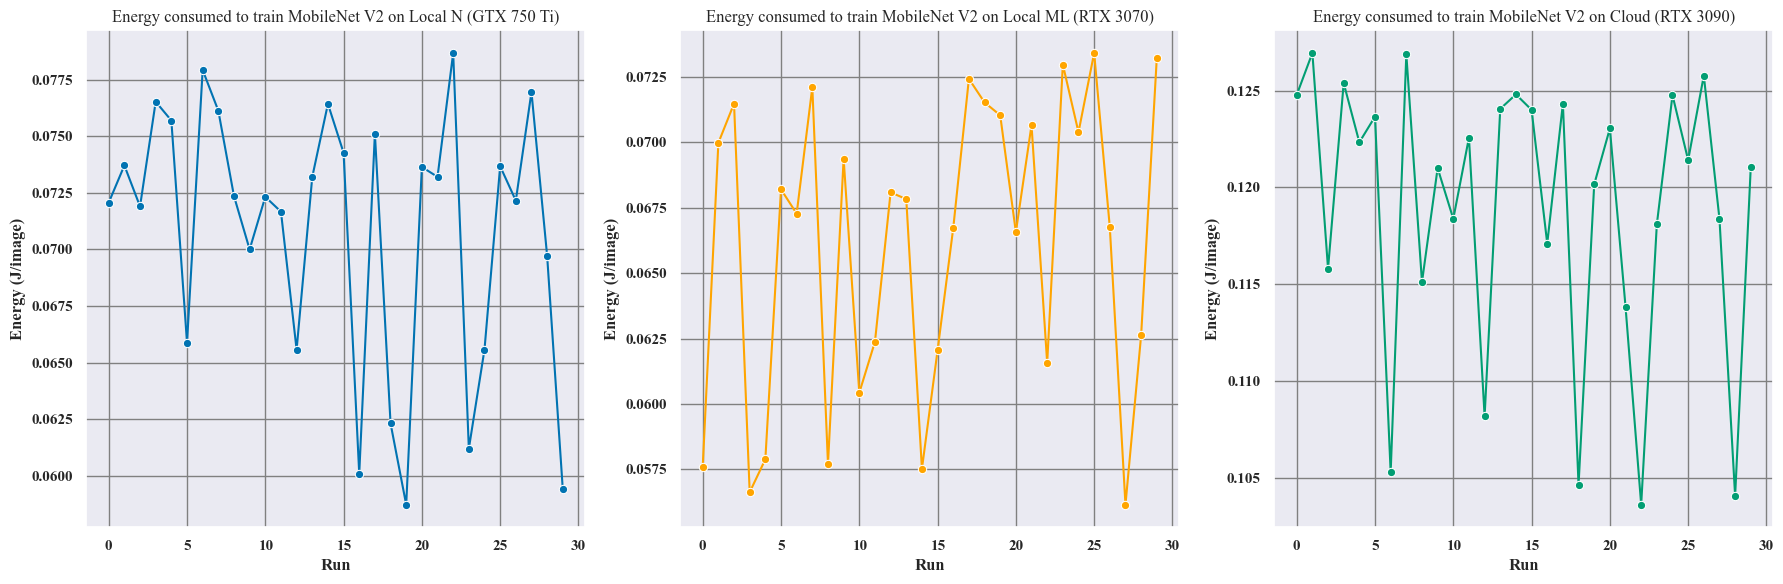

In [6]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 6))
ax = sns.lineplot(data=local_n_mobilenet, x="run", y="energy", ax=ax0, marker="o", color=COLORS["Local N"])
ax.set_ylabel("Energy (J/image)")
ax.set_xlabel("Run")
ax.set_title("Energy consumed to train MobileNet V2 on Local N (GTX 750 Ti)")

ax = sns.lineplot(data=local_ml_mobilenet.iloc[:30], x="run", y="energy", ax=ax1, marker="o", color=COLORS["Local ML"])
ax.set_ylabel("Energy (J/image)")
ax.set_xlabel("Run")
ax.set_title("Energy consumed to train MobileNet V2 on Local ML (RTX 3070)")

ax = sns.lineplot(data=cloud_mobilenet, x="run", y="energy", ax=ax2, marker="o", color=COLORS["Cloud"])
ax.set_ylabel("Energy (J/image)")
ax.set_xlabel("Run")
ax.set_title("Energy consumed to train MobileNet V2 on Cloud (RTX 3090)")

fig.tight_layout()

##### Cloud
Looking at the boxplots we observe some extreme outliers. In this case in the NASNet, Xception and VGG16 architectures.

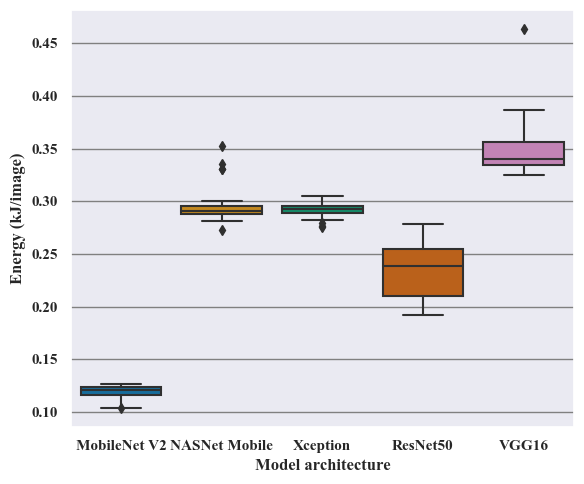

In [7]:
boxplot(
    pd.concat([cloud_mobilenet, cloud_nasnet, cloud_xception, cloud_resnet50, cloud_vgg16]),
    x="architecture",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (kJ/image)",
    figname=f"cloud-energy-boxplot.{FIGURES_FORMAT}",
    figsize=(6, 5),
)

We manually inspect the outliers to see if they should be removed or not.

In [8]:
sorted_cloud_nasnet = cloud_nasnet.sort_values(by="energy", ascending=False)
pd.concat([sorted_cloud_nasnet.iloc[:5], sorted_cloud_nasnet.iloc[-5:]])[
    [
        "run",
        "training duration (h)",
        "trained epochs",
        "gpu_usage",
        "temperature",
        "raw energy",
        "energy",
        "normalized duration",
    ]
]

,run,training duration (h),trained epochs,gpu_usage,temperature,raw energy,energy,normalized duration
31,1,1.688808,95,34.553248,56.873228,1.136436,0.352335,1.884924
30,0,1.374044,82,35.466208,57.039255,0.932775,0.335041,1.776741
32,2,1.157140,68,33.389476,56.491831,0.763600,0.330744,1.804322
33,3,1.300914,78,35.315879,56.850823,0.875249,0.330500,1.768443
50,20,1.276295,90,42.727491,54.606497,0.917004,0.300098,1.503646
53,23,0.999810,73,41.592098,54.235114,0.704597,0.284284,1.452218
43,13,0.995117,73,41.935141,54.285155,0.702135,0.283291,1.445401
37,7,0.975052,72,41.643367,54.558345,0.691668,0.282943,1.435927
38,8,0.940801,70,41.771141,54.534595,0.667462,0.280843,1.425072
45,15,0.849968,64,41.209493,54.024550,0.593168,0.272981,1.408185


In [9]:
sorted_cloud_xception = cloud_xception.sort_values(by="energy", ascending=False)
pd.concat([sorted_cloud_xception.iloc[:10], sorted_cloud_xception.iloc[-10:]])[
    [
        "run",
        "training duration (h)",
        "trained epochs",
        "gpu_usage",
        "temperature",
        "raw energy",
        "energy",
        "normalized duration",
    ]
]

,run,training duration (h),trained epochs,gpu_usage,temperature,raw energy,energy,normalized duration
138,18,1.132989,106,60.091288,62.834601,1.096400,0.304648,1.133332
131,11,1.150497,108,60.352102,62.981634,1.116304,0.304434,1.129533
120,0,1.092949,103,60.305775,62.979649,1.059447,0.302954,1.125122
129,9,1.052702,98,59.246430,62.670809,1.007082,0.302673,1.138981
132,12,0.968240,91,58.961771,62.564530,0.922121,0.298457,1.128181
139,19,0.954149,91,59.355478,62.699883,0.918816,0.297387,1.111763
133,13,0.939701,90,59.578107,62.661834,0.905550,0.296350,1.107093
146,26,0.915743,88,60.079635,62.820365,0.884068,0.295895,1.103388
140,20,0.922731,89,60.222959,62.820428,0.893467,0.295681,1.099315
127,7,0.914669,88,59.518564,62.764151,0.881969,0.295193,1.102094


In [10]:
sorted_cloud_vgg16 = cloud_vgg16.sort_values(by="energy", ascending=False)
pd.concat([sorted_cloud_vgg16.iloc[:5], sorted_cloud_vgg16.iloc[-5:]])[
    [
        "run",
        "training duration (h)",
        "trained epochs",
        "gpu_usage",
        "temperature",
        "raw energy",
        "energy",
        "normalized duration",
    ]
]

,run,training duration (h),trained epochs,gpu_usage,temperature,raw energy,energy,normalized duration
116,26,1.179458,91,94.128568,64.980656,1.431716,0.463394,1.374289
114,24,0.912780,84,91.826882,64.651935,1.101893,0.386362,1.152190
94,4,0.806481,76,92.689548,64.973784,0.982598,0.380800,1.125169
90,0,1.019880,98,90.417349,64.718494,1.227056,0.368785,1.103469
99,9,0.850699,83,91.527469,64.735448,1.023863,0.363328,1.086764
108,18,0.722120,77,89.649461,64.699923,0.870332,0.332912,0.994388
100,10,0.722126,77,89.660632,64.694145,0.869200,0.332479,0.994397
101,11,0.743549,80,90.426861,64.789375,0.895275,0.329610,0.985500
91,1,0.700975,76,89.948016,64.735714,0.845963,0.327848,0.977971
103,13,0.658459,72,89.983101,64.622729,0.793311,0.324523,0.969691


In [11]:
cloud_vgg16_no_energy_outliers = sorted_cloud_vgg16.iloc[1:]
print("Cloud VGG16 remaining samples:", cloud_vgg16_no_energy_outliers.shape[0])

Cloud VGG16 remaining samples: 29


After inspecting the data, we decide to remove the extreme outliers VGG16 architecture.

##### Local ML
Again, we observe some outliers. In this case in the Xception architecture.

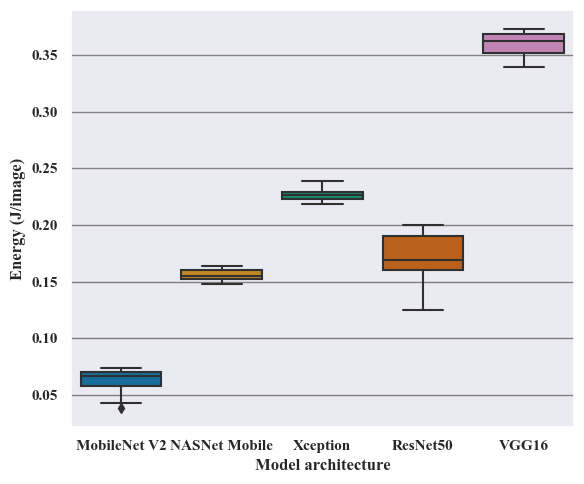

In [12]:
boxplot(
    pd.concat(
        [
            local_ml_mobilenet,
            local_ml_nasnet,
            local_ml_xception,
            local_ml_resnet50,
            local_ml_vgg16,
        ]
    ),
    x="architecture",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (J/image)",
    figname=f"local-v2-energy-boxplot.{FIGURES_FORMAT}",
    figsize=(6, 5),
)

We proceed to review the outliers to decide whether to remove them or not. Looking at the data, it seems the outliers are a natural outcome of the training process rather than a measurement error or sampling problems.

In [13]:
local_ml_xception.sort_values(by="energy", ascending=False)[
    [
        "run",
        "training duration (h)",
        "trained epochs",
        "gpu_usage",
        "temperature",
        "raw energy",
        "energy",
        "normalized duration",
    ]
]

,run,training duration (h),trained epochs,gpu_usage,temperature,raw energy,energy,normalized duration
368,29,1.139417,97,92.827191,64.843300,0.785294,0.238449,1.245513
367,28,1.099361,94,93.179863,64.800911,0.756308,0.236977,1.240079
363,24,1.023988,89,93.256654,64.736828,0.706121,0.233681,1.219950
361,22,0.956943,84,92.972973,64.576286,0.658651,0.230946,1.207936
366,27,0.918272,81,92.964264,64.763174,0.632158,0.229866,1.202052
350,11,0.919678,80,93.107650,64.706078,0.623155,0.229425,1.218941
341,2,0.889346,79,92.811445,65.683240,0.615137,0.229340,1.193660
348,9,1.022872,90,92.931485,64.745242,0.700604,0.229279,1.205080
352,13,0.944421,83,93.225559,64.701413,0.645517,0.229068,1.206492
340,1,0.874325,78,92.970420,65.704517,0.604991,0.228449,1.188544


##### Local vs. Cloud
For the Local vs. Cloud analysis of energy, we consider the outliers in the Local ML to be have a negligible difference compared to the rest of the samples in the group. Therefore, we do not remove any outliers.

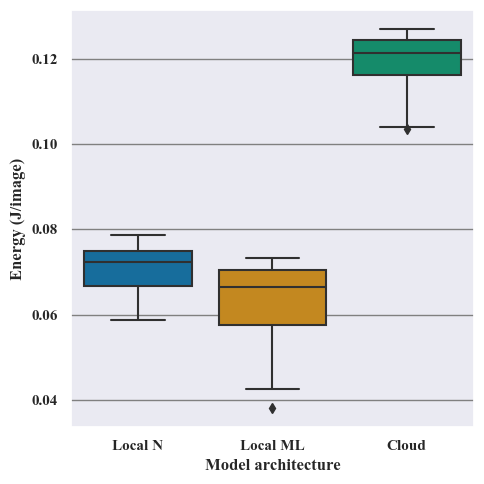

In [14]:
boxplot(
    pd.concat([local_n_mobilenet, local_ml_mobilenet, cloud_mobilenet]),
    x="training environment",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (J/image)",
    figname=f"local-vs-cloud-energy-boxplot.{FIGURES_FORMAT}",
)

#### GPU usage
##### Cloud

For the GPU usage we observe the presence of outliers in the MobileNet V2, NASNet Mobile, ResNet50 and VGG16 measurements. However, we only remove the outliers of the NASNet and ResNet50 architectures, which are the most extreme.

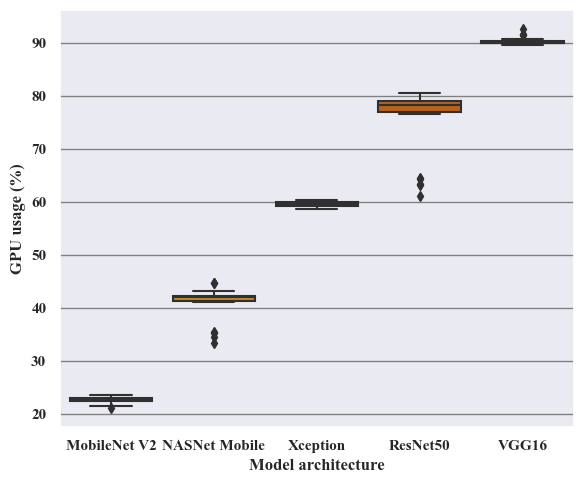

In [15]:
cloud_gpu_data = pd.concat(
    [
        cloud_mobilenet,
        cloud_nasnet,
        cloud_xception,
        cloud_resnet50,
        cloud_vgg16_no_energy_outliers,
    ]
)
boxplot(
    cloud_gpu_data,
    x="architecture",
    y="gpu_usage",
    xlabel="Model architecture",
    ylabel="GPU usage (%)",
    figname=f"cloud-gpu_usage-boxplot.{FIGURES_FORMAT}",
    figsize=(6, 5),
)

In [16]:
cloud_nasnet_no_gpu_outliers = cloud_nasnet.sort_values(by="gpu_usage", ascending=True).iloc[3:]
print("Cloud NASNet remaining samples:", cloud_nasnet_no_gpu_outliers.shape[0])
cloud_resnet50_no_gpu_outliers = cloud_resnet50.sort_values(by="gpu_usage", ascending=True).iloc[5:]
print("Cloud ResNet50 remaining samples:", cloud_resnet50_no_gpu_outliers.shape[0])

Cloud NASNet remaining samples: 27
Cloud ResNet50 remaining samples: 25


##### Local ML

In the Local ML environment, we observe that only MobileNet V2 has extreme outliers. We decide to remove them.

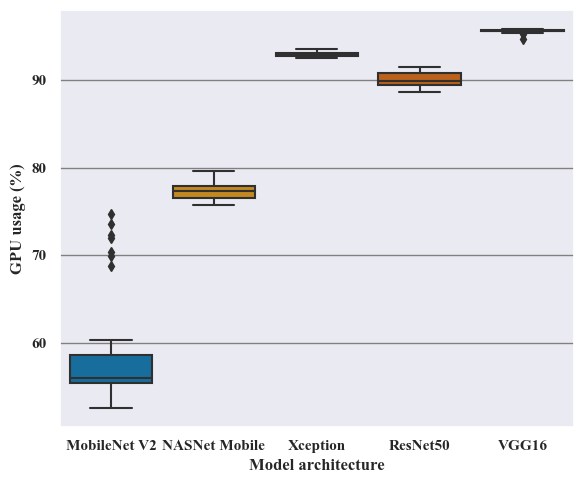

In [17]:
boxplot(
    pd.concat(
        [
            local_ml_mobilenet,
            local_ml_nasnet,
            local_ml_xception,
            local_ml_resnet50,
            local_ml_vgg16,
        ]
    ),
    x="architecture",
    y="gpu_usage",
    xlabel="Model architecture",
    ylabel="GPU usage (%)",
    figname=f"local-v2-gpu_usage-boxplot.{FIGURES_FORMAT}",
    figsize=(6, 5),
)

In [18]:
local_ml_mobilenet_no_gpu_outliers = local_ml_mobilenet.sort_values(by="gpu_usage", ascending=True).iloc[:-7]
print("Local ML MobileNet remaining samples:", local_ml_mobilenet_no_gpu_outliers.shape[0])

Local ML MobileNet remaining samples: 30


##### Local vs. Cloud

For the Local vs. Cloud analysis of GPU usage, we do not observe any extreme outliers that should be removed.

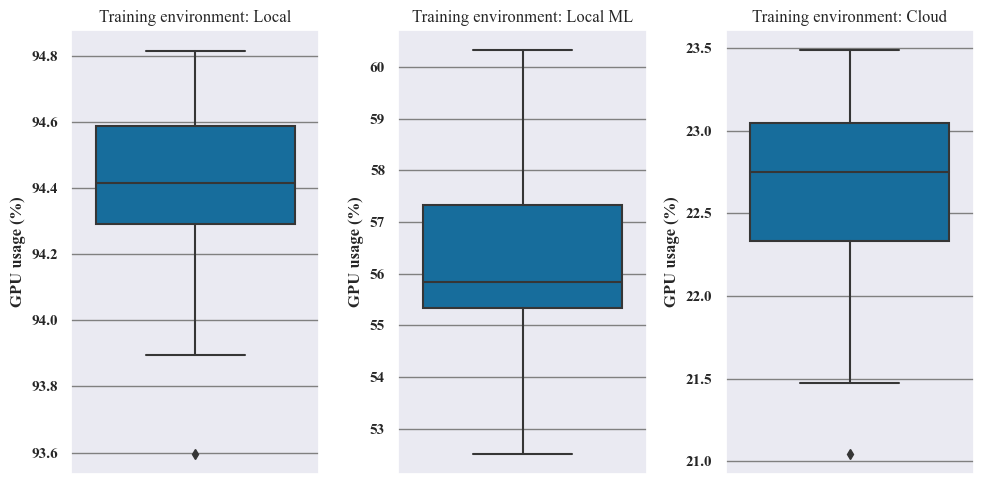

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
sns.boxplot(y=local_n_mobilenet.gpu_usage, ax=ax1)
ax1.set_ylabel("GPU usage (%)")
ax1.set_title("Training environment: Local")

sns.boxplot(y=local_ml_mobilenet_no_gpu_outliers.gpu_usage, ax=ax2)
ax2.set_ylabel("GPU usage (%)")
ax2.set_title("Training environment: Local ML")

sns.boxplot(y=cloud_mobilenet.gpu_usage, ax=ax3)
ax3.set_ylabel("GPU usage (%)")
ax3.set_title("Training environment: Cloud")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"cloud-local-gpu_usage-boxplot.{FIGURES_FORMAT}"))

#### Temperature
##### Cloud
Now we look for outliers in the temperature of the Cloud architecture. If we look at the boxplots, we observe that the Xception and VGG16 architectures have some outliers. However, these outliers are not extreme and we decide to keep them.

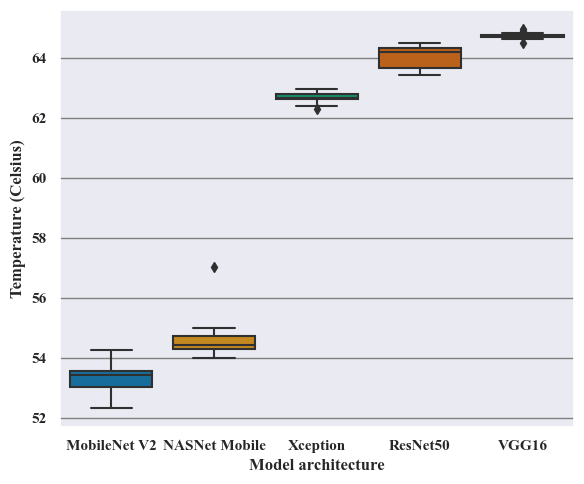

In [20]:
boxplot(
    pd.concat(
        [
            cloud_mobilenet,
            cloud_nasnet_no_gpu_outliers,
            cloud_xception,
            cloud_resnet50_no_gpu_outliers,
            cloud_vgg16_no_energy_outliers,
        ]
    ),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname=f"cloud-temp-boxplot.{FIGURES_FORMAT}",
    figsize=(6, 5),
)

##### Local N
We check the outliers for the Local "Normal User" environment. In this case, we do not observe any outliers in the data.

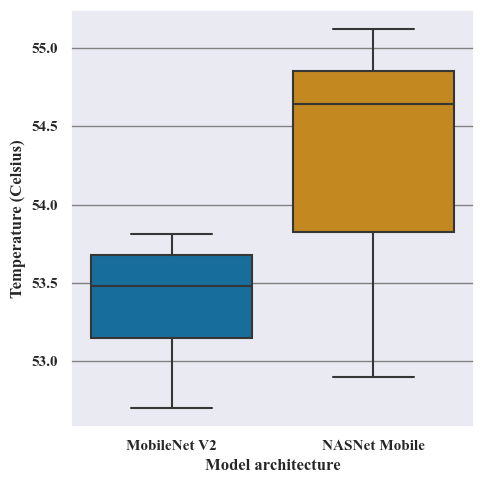

In [21]:
boxplot(
    pd.concat([local_n_mobilenet, local_n_nasnet]),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname=f"local-temp-boxplot.{FIGURES_FORMAT}",
)

##### Local ML
In the Local ML environment, we observe that MobileNet V2, Xception, and ResNet50 have outliers. However, we decide to keep them given the small difference in temperature of the outliers with the remaining samples of each group.

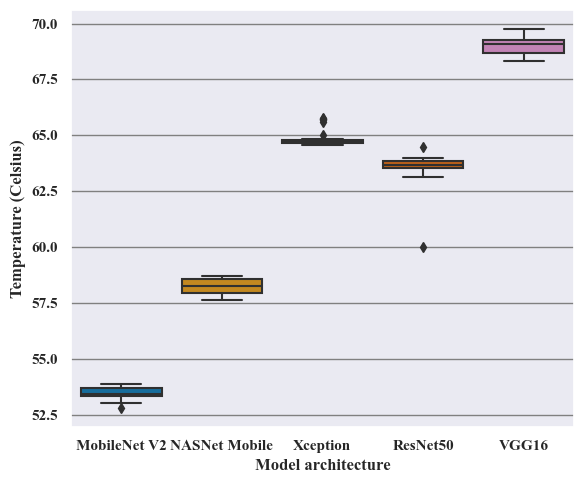

In [22]:
boxplot(
    pd.concat(
        [
            local_ml_mobilenet_no_gpu_outliers,
            local_ml_nasnet,
            local_ml_xception,
            local_ml_resnet50,
            local_ml_vgg16,
        ]
    ),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname=f"local-v2-temp-boxplot.{FIGURES_FORMAT}",
    figsize=(6, 5),
)

#### $F_1$ score
Given that the variation in $F_1$ score is a natural outcome of the training process, we only remove those samples that have a $F_1$ score of 0. This is because a $F_1$ score of 0 indicates that the model is not able to predict any of the classes, which is a extraneous behavior.

In [23]:
mobilenet = pd.concat([local_n_mobilenet, local_ml_mobilenet_no_gpu_outliers, cloud_mobilenet])
nasnet = pd.concat([local_n_nasnet, local_ml_nasnet, cloud_nasnet_no_gpu_outliers])
xception = pd.concat([local_ml_xception, cloud_xception])
resnet50 = pd.concat([local_ml_resnet50, cloud_resnet50_no_gpu_outliers])
vgg16 = pd.concat([local_ml_vgg16, cloud_vgg16_no_energy_outliers])
f1_df = pd.concat([mobilenet, nasnet, xception, resnet50, vgg16]).query("`f1-score` > 0")

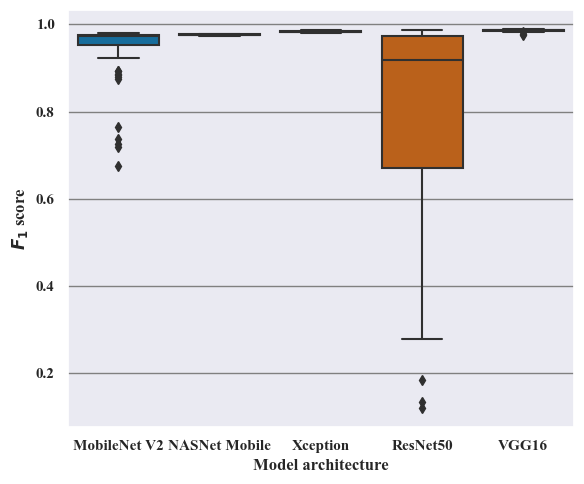

In [24]:
boxplot(
    f1_df,
    x="architecture",
    y="f1-score",
    xlabel="Model architecture",
    ylabel="$F_1$ score",
    figname=f"f1score-boxplot.{FIGURES_FORMAT}",
    figsize=(6, 5),
)

### Impact of temperature on energy consumption

In [25]:
temp_vs_energy_df = pd.concat(
    [
        cloud_mobilenet,
        cloud_nasnet_no_gpu_outliers,
        cloud_xception,
        cloud_resnet50_no_gpu_outliers,
        cloud_vgg16_no_energy_outliers,
        local_n_mobilenet,
        local_n_nasnet,
        local_ml_mobilenet_no_gpu_outliers,
        local_ml_nasnet,
        local_ml_xception,
        local_ml_resnet50,
        local_ml_vgg16,
    ]
)

Looking at the scatter plot of the temperature vs. energy, we do not observe any clear correlation between the two variables in a general view. However, this might not be the case when we look at the data for each environment separately.

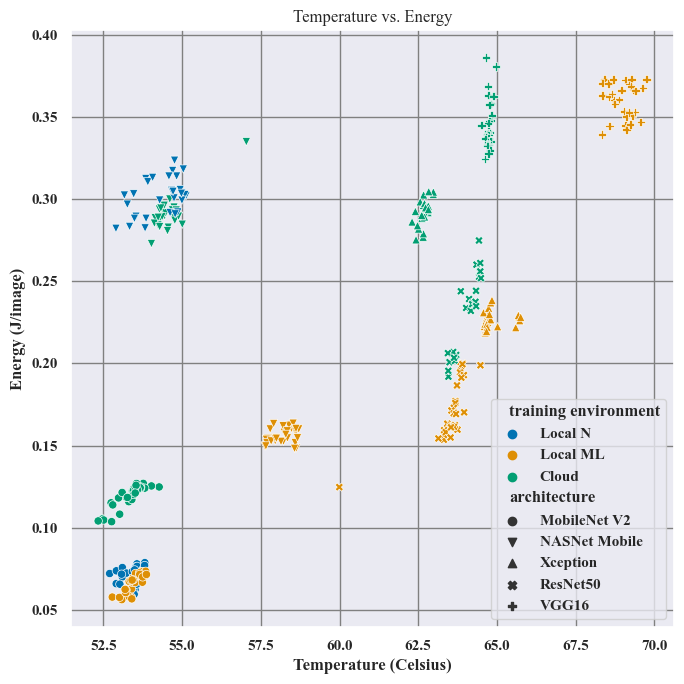

In [26]:
_, axes = plt.subplots(1, 1, figsize=((7, 7)))
ax = sns.scatterplot(
    temp_vs_energy_df,
    x="temperature",
    y="energy",
    ax=axes,
    style="architecture",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    markers=MARKERS,
)
ax.set_title("Temperature vs. Energy")
ax.set_xlabel("Temperature (Celsius)")
ax.set_ylabel("Energy (J/image)")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"temperature-energy-scatter.{FIGURES_FORMAT}"))

plt.show()

#### Test normality assumption
Before performing any statistical analysis, we need to check if the data is normally distributed. We do this by observing the Q-Q plot of the data and by performing the Shapiro-Wilk test.

Shapiro test for normality of group 0: W = 0.761440098285675 and p-value 7.311179792005365e-14
Shapiro test for normality of group 1: W = 0.865877628326416 and p-value 5.671718650290813e-10
Levene test for equal variances: W = 167.9012823828945 and p-value = 2.114011493708023e-30


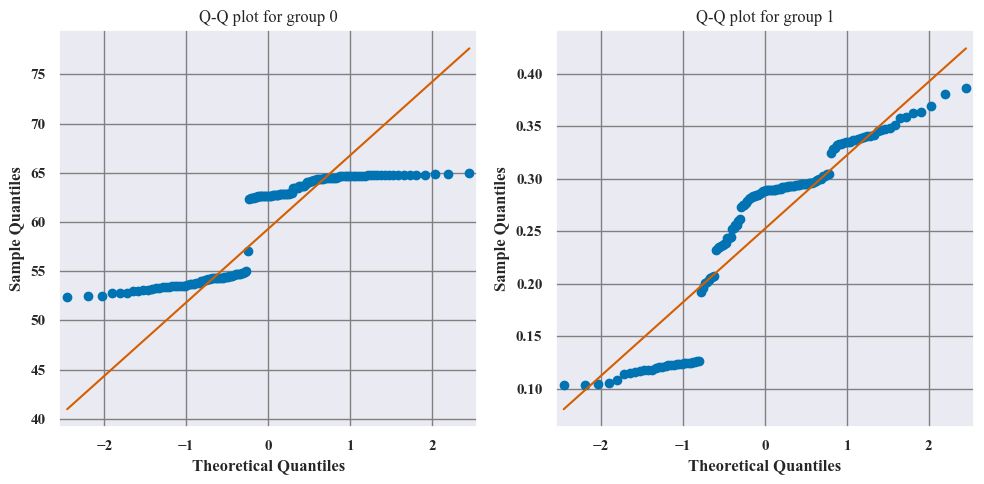

In [27]:
cloud_df = temp_vs_energy_df.query("`training environment` == 'Cloud'")
test_assumptions(cloud_df["temperature"], cloud_df["energy"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.9090379476547241 and p-value 0.00028551919967867434
Shapiro test for normality of group 1: W = 0.701137363910675 and p-value 9.332083994451068e-10
Levene test for equal variances: W = 61.25026136012563 and p-value = 2.3902775351659964e-12


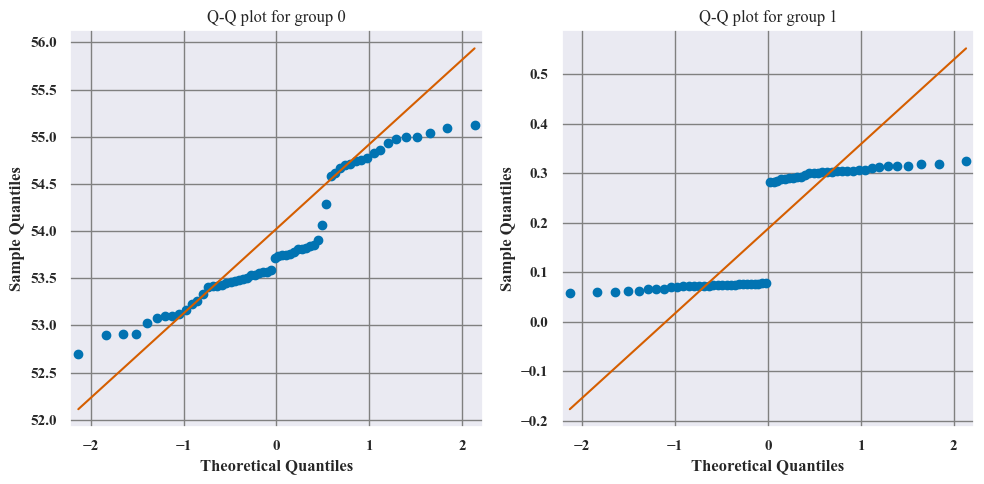

In [28]:
local_n_df = temp_vs_energy_df.query("`training environment` == 'Local N'")
test_assumptions(local_n_df["temperature"], local_n_df["energy"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.8964983820915222 and p-value 7.090301679113509e-09
Shapiro test for normality of group 1: W = 0.8935980200767517 and p-value 4.907620976268845e-09
Levene test for equal variances: W = 236.76958611399604 and p-value = 7.542175655001021e-40


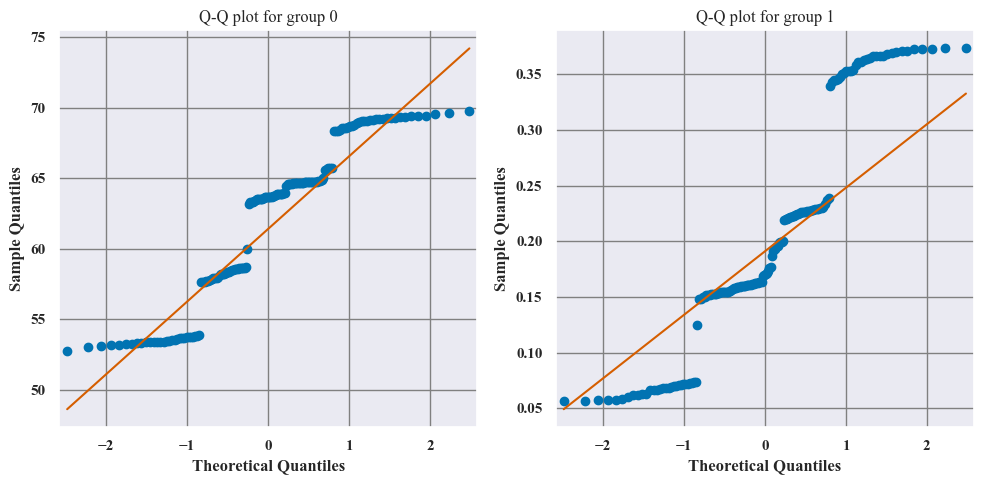

In [29]:
local_ml_df = temp_vs_energy_df.query("`training environment` == 'Local ML'")
test_assumptions(local_ml_df["temperature"], local_ml_df["energy"], nrows=1, ncols=2, figsize=(10, 5))

The visual assessment and the Shapiro-Wilk test indicate that the data is not normally distributed. Therefore, we perform the Spearman's rank correlation test.

#### Spearman's rank correlation test
The results of the correlation test show that there is a positive correlation between temperature and energy consumption. However, we observe different behaviors depending on the environment.

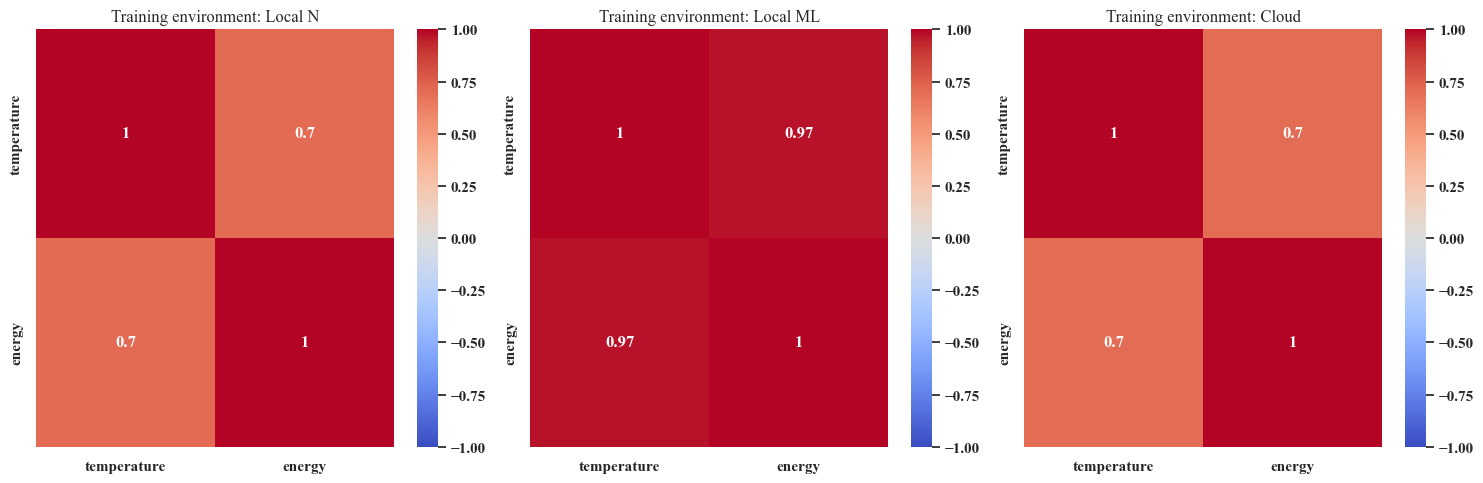

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, strategy in enumerate(TRAIN_STRATEGIES):
    data = temp_vs_energy_df.query("`training environment` == @strategy")[["temperature", "energy"]]

    corr = data.corr("spearman")
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[i], cmap="coolwarm")
    ax.set_title(f"Training environment: {strategy}")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"temperature-energy-correlation.{FIGURES_FORMAT}"))

### Impact of temperature on GPU usage

As with the energy consumption, we do not observe a particular correlation between temperature and GPU usage in a general view. However, when looking at the data for each environment separately, we there seems to be a positive correlation between temperature and GPU usage.

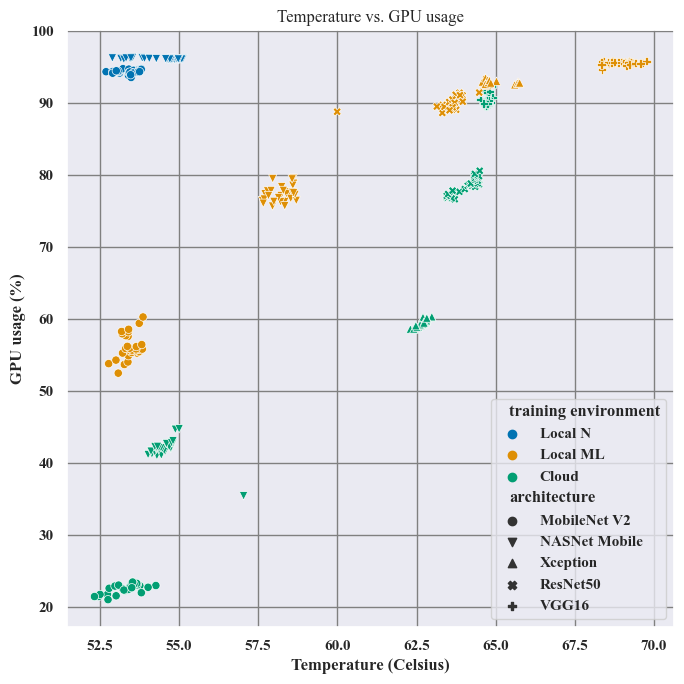

In [31]:
_, axes = plt.subplots(1, 1, figsize=((7, 7)))
ax = sns.scatterplot(
    temp_vs_energy_df,
    x="temperature",
    y="gpu_usage",
    ax=axes,
    style="architecture",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    markers=MARKERS,
)
ax.set_title("Temperature vs. GPU usage")
ax.set_xlabel("Temperature (Celsius)")
ax.set_ylabel("GPU usage (%)")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"temperature-gpu_usage-scatter.{FIGURES_FORMAT}"))

plt.show()

#### Test normality assumption
As in the previous correlation analysis, we check the normality of the data.

Shapiro test for normality of group 0: W = 0.761440098285675 and p-value 7.311179792005365e-14
Shapiro test for normality of group 1: W = 0.8903614282608032 and p-value 8.814802221479567e-09
Levene test for equal variances: W = 216.15503359129335 and p-value = 1.1806325399196315e-36


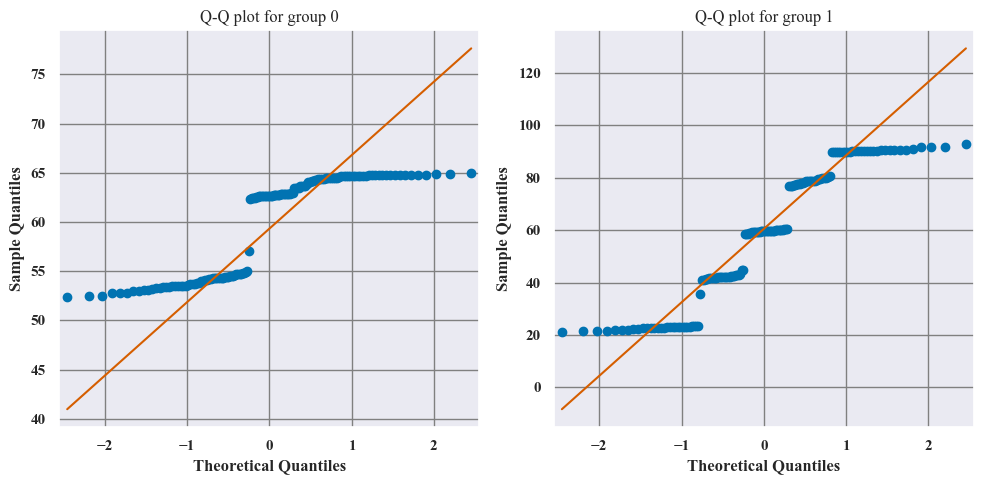

In [32]:
cloud_df = temp_vs_energy_df.query("`training environment` == 'Cloud'")
test_assumptions(cloud_df["temperature"], cloud_df["gpu_usage"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.9090379476547241 and p-value 0.00028551919967867434
Shapiro test for normality of group 1: W = 0.7974491715431213 and p-value 1.1669445143525081e-07
Levene test for equal variances: W = 28.660322247087283 and p-value = 4.3089620006896495e-07


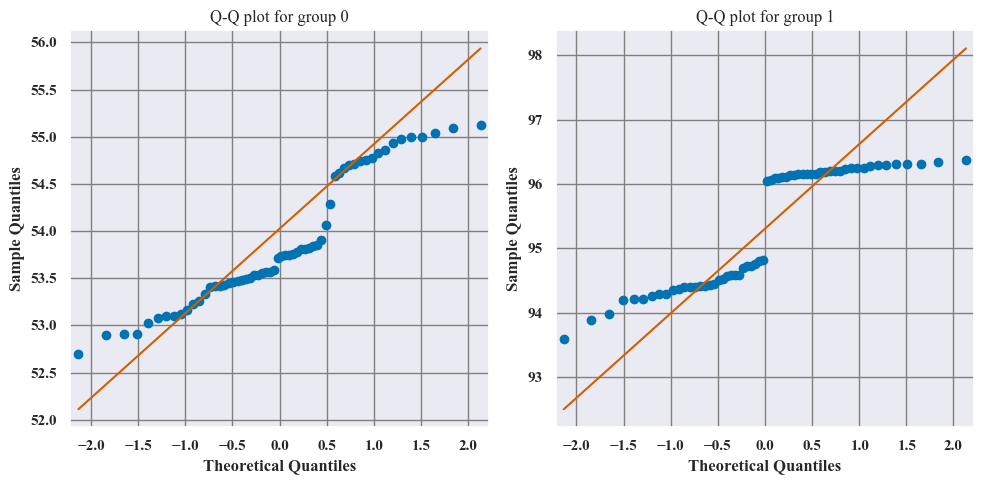

In [33]:
local_n_df = temp_vs_energy_df.query("`training environment` == 'Local N'")
test_assumptions(local_n_df["temperature"], local_n_df["gpu_usage"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.9090379476547241 and p-value 0.00028551919967867434
Shapiro test for normality of group 1: W = 0.7974491715431213 and p-value 1.1669445143525081e-07
Levene test for equal variances: W = 28.660322247087283 and p-value = 4.3089620006896495e-07


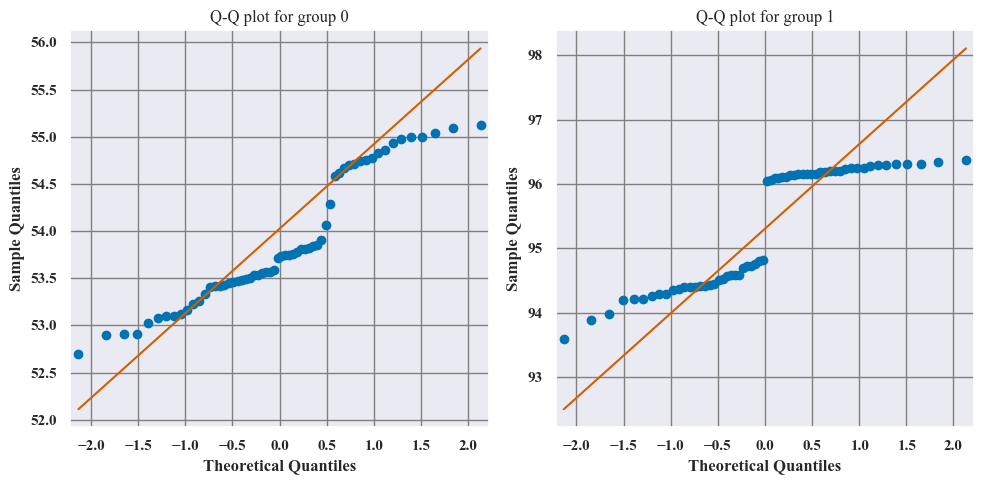

In [34]:
local_ml_df = temp_vs_energy_df.query("`training environment` == 'Local ML'")
test_assumptions(local_n_df["temperature"], local_n_df["gpu_usage"], nrows=1, ncols=2, figsize=(10, 5))

The visual assessment and the Shapiro-Wilk test indicate that the data is not normally distributed. Therefore, we perform the Spearman's rank correlation test.

#### Spearman's rank correlation test
The results of the correlation test show that there is a positive correlation between temperature and energy consumption. Moreover, we find a very strong correlation between temperature and GPU usage in the Local ML and Cloud environments.

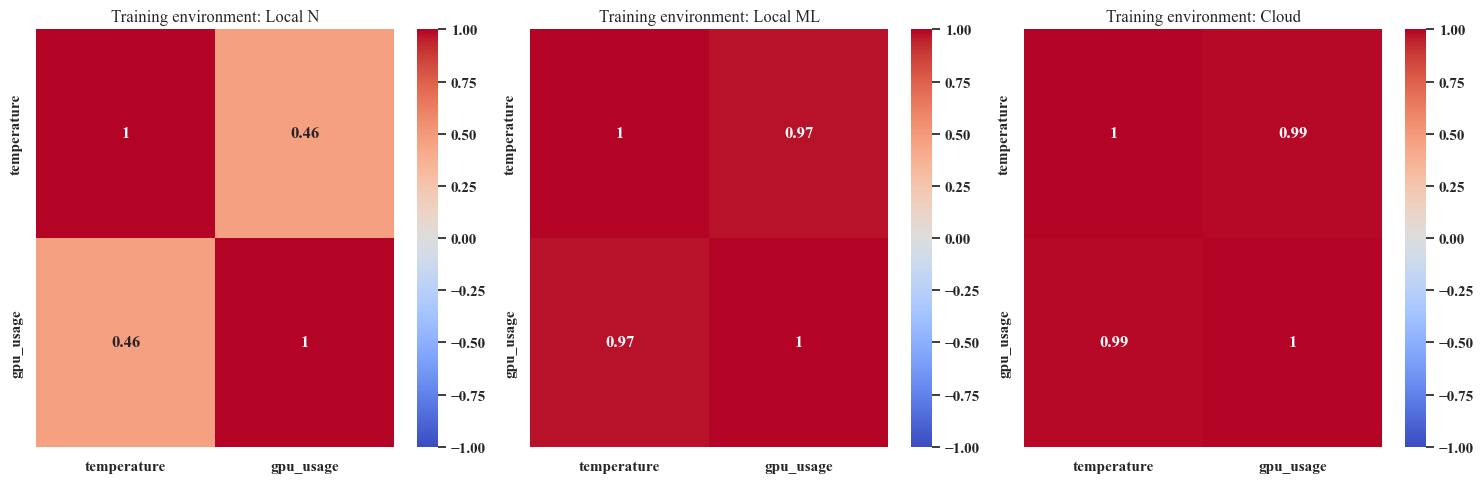

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, strategy in enumerate(TRAIN_STRATEGIES):
    data = temp_vs_energy_df.query("`training environment` == @strategy")[["temperature", "gpu_usage"]]
    corr = data.corr("spearman")
    # print(strategy)
    # print(corr, end="\n\n")
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[i], cmap="coolwarm")
    ax.set_title(f"Training environment: {strategy}")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"temperature-gpu_usage-correlation.{FIGURES_FORMAT}"))

### Comparison between model architectures and training environment
#### Energy comparison

In [36]:
analysis_df_no_outliers = (
    pd.concat(
        [
            cloud_mobilenet,
            cloud_nasnet_no_gpu_outliers,
            cloud_xception,
            cloud_resnet50_no_gpu_outliers,
            cloud_vgg16_no_energy_outliers,
            local_n_mobilenet,
            local_n_nasnet,
            local_ml_mobilenet_no_gpu_outliers,
            local_ml_nasnet,
            local_ml_xception,
            local_ml_resnet50,
            local_ml_vgg16,
        ]
    )
    .query("`f1-score` > 0")
    .sort_values(by=["GFLOPs", "training environment", "architecture"], ascending=True)
    .reset_index(drop=True)
)

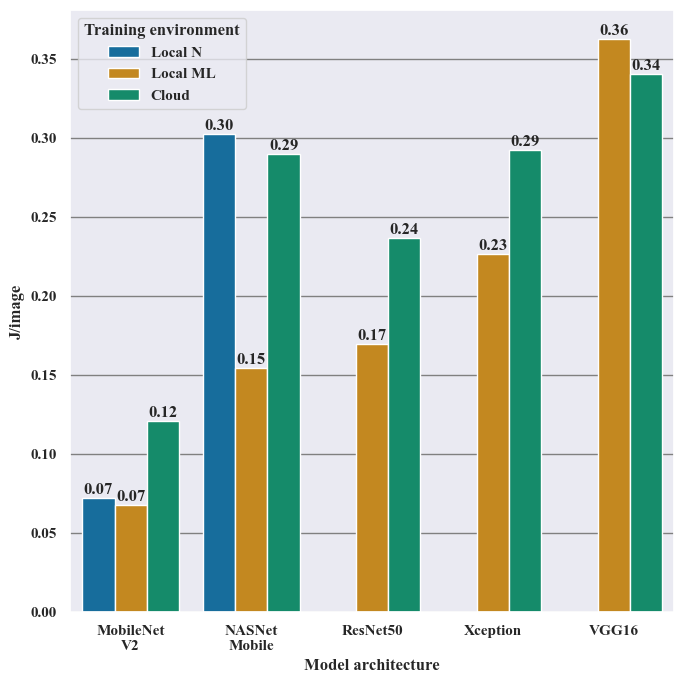

In [37]:
_, ax1 = plt.subplots(1, 1, figsize=((7, 7)))
_, ax = barplot(
    analysis_df_no_outliers,
    x="architecture",
    y="energy",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    xlabel="Model architecture",
    ylabel="J/image",
    barlabel=True,
    ax=ax1,
)
ax.legend(title="Training environment", loc="upper left")
labels = [label.get_text().replace(" ", "\n") for label in ax1.get_xticklabels()]
ax1.set_xticklabels(labels)

plt.savefig(os.path.join(FIGURES_DIR, f"energy-comparison-full.{FIGURES_FORMAT}"))

##### Energy improvement within architectures

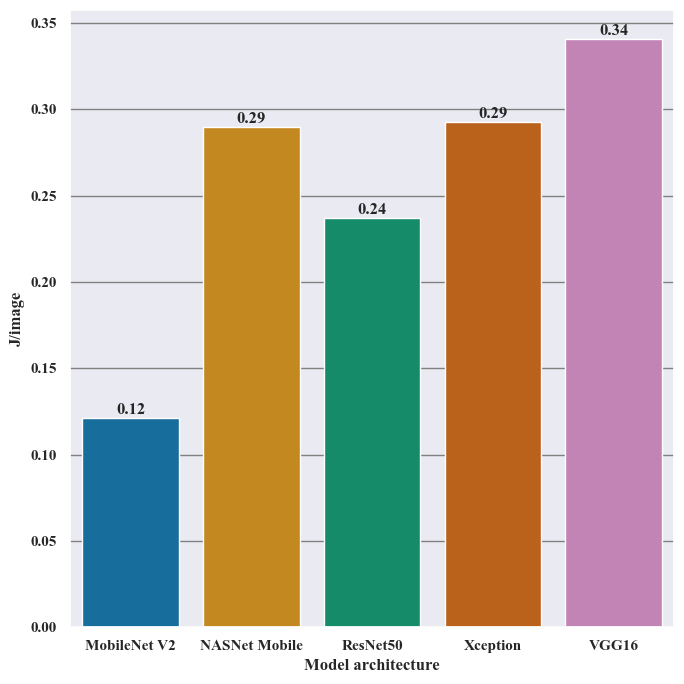

In [38]:
_, ax1 = plt.subplots(1, 1, figsize=((7, 7)))
_, ax = barplot(
    analysis_df_no_outliers.query("`training environment` == 'Cloud'"),
    x="architecture",
    y="energy",
    estimator="median",
    xlabel="Model architecture",
    ylabel="J/image",
    barlabel=True,
    ax=ax1,
)

plt.savefig(os.path.join(FIGURES_DIR, f"energy-comparison-cloud.{FIGURES_FORMAT}"))

In [39]:
improvement = (
    cloud_vgg16_no_energy_outliers.energy.median() - cloud_mobilenet.energy.median()
) / cloud_vgg16_no_energy_outliers.energy.median()
print(f"Maximum improvement: {improvement}")

Maximum improvement: 0.6438371908446173


In [40]:
improvement = (
    cloud_vgg16_no_energy_outliers.energy.median() - cloud_xception.energy.median()
) / cloud_vgg16_no_energy_outliers.energy.median()
print(f"Minimum improvement: {improvement}")

Minimum improvement: 0.14048814136231333


##### Energy improvement within training strategies

In [41]:
improvement = (
    cloud_mobilenet.energy.median() - local_ml_mobilenet_no_gpu_outliers.energy.median()
) / cloud_mobilenet.energy.median()
print(f"Maximum improvement: {improvement}")

Maximum improvement: 0.44277948397464423


In [42]:
improvement = (cloud_mobilenet.energy.median() - local_n_mobilenet.energy.median()) / cloud_mobilenet.energy.median()
print(f"Minimum improvement: {improvement}")

Minimum improvement: 0.40333951512548644


##### Overall energy improvement

In [43]:
print_improvement(analysis_df_no_outliers, "energy")

Maximum improvement: 0.8138637397120754 (VGG16 - Local ML, MobileNet V2 - Local ML)
Minimum improvement: 0.009979063062473094 (Xception - Cloud, NASNet Mobile - Cloud)


#### GPU usage comparison

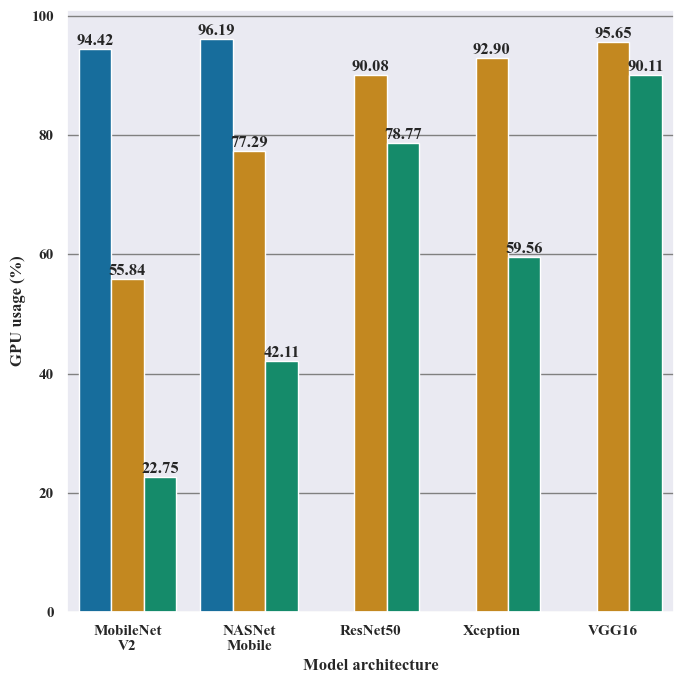

In [44]:
_, ax1 = plt.subplots(1, 1, figsize=((7, 7)))
_, ax = barplot(
    analysis_df_no_outliers,
    x="architecture",
    y="gpu_usage",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    xlabel="Model architecture",
    ylabel="GPU usage (%)",
    barlabel=True,
    ax=ax1,
)

labels = [label.get_text().replace(" ", "\n") for label in ax1.get_xticklabels()]
ax1.set_xticklabels(labels)

ax.get_legend().remove()
plt.savefig(os.path.join(FIGURES_DIR, f"gpu-comparison-full.{FIGURES_FORMAT}"))

#### GPU usage comparison within architectures

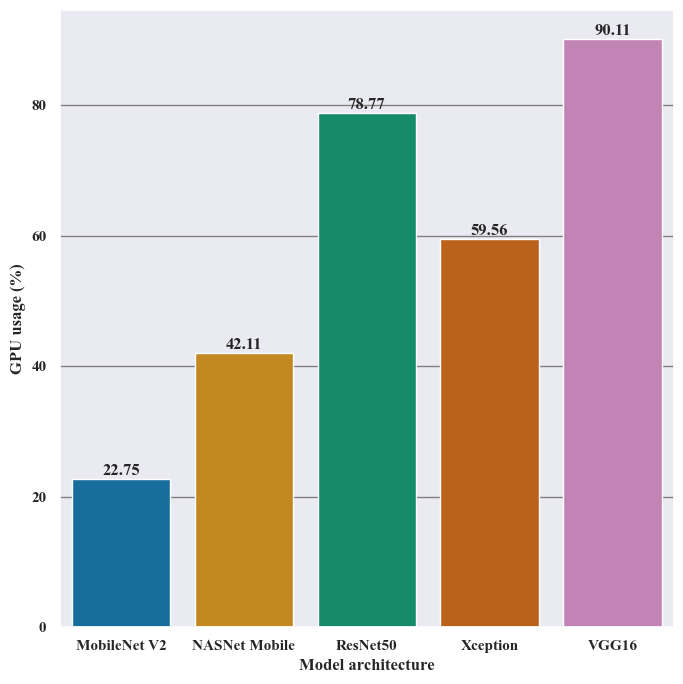

In [45]:
_, ax1 = plt.subplots(1, 1, figsize=((7, 7)))
_, ax = barplot(
    analysis_df_no_outliers.query("`training environment` == 'Cloud'"),
    x="architecture",
    y="gpu_usage",
    estimator="median",
    xlabel="Model architecture",
    ylabel="GPU usage (%)",
    barlabel=True,
    ax=ax1,
)

plt.savefig(os.path.join(FIGURES_DIR, f"gpu-comparison-cloud.{FIGURES_FORMAT}"))

#### Training time comparison

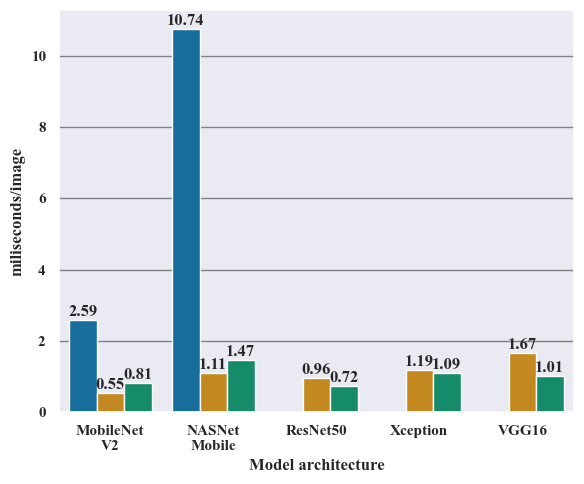

In [46]:
_, ax = barplot(
    analysis_df_no_outliers,
    x="architecture",
    y="normalized duration",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    xlabel="Model architecture",
    ylabel="miliseconds/image",
    barlabel=True,
    figsize=(6, 5),
)

labels = [label.get_text().replace(" ", "\n") for label in ax.get_xticklabels()]
ax.set_xticklabels(labels)

ax.get_legend().remove()

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"training-time-comparison-full.{FIGURES_FORMAT}"))

#### Training time comparison within architectures

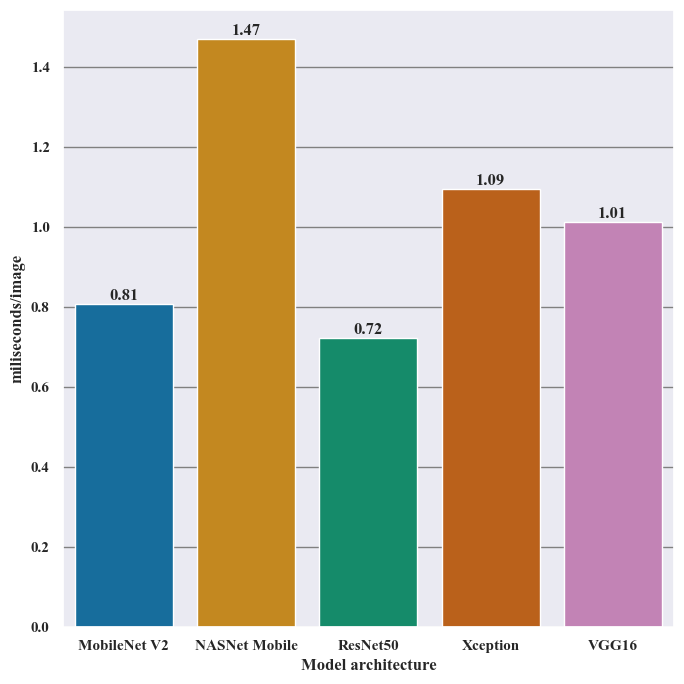

In [47]:
_, ax = barplot(
    analysis_df_no_outliers.query("`training environment` == 'Cloud'"),
    x="architecture",
    y="normalized duration",
    estimator="median",
    xlabel="Model architecture",
    ylabel="miliseconds/image",
    barlabel=True,
    figsize=(7, 7),
)

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"training-time-comparison-cloud.{FIGURES_FORMAT}"))

#### $F_1$ score comparison

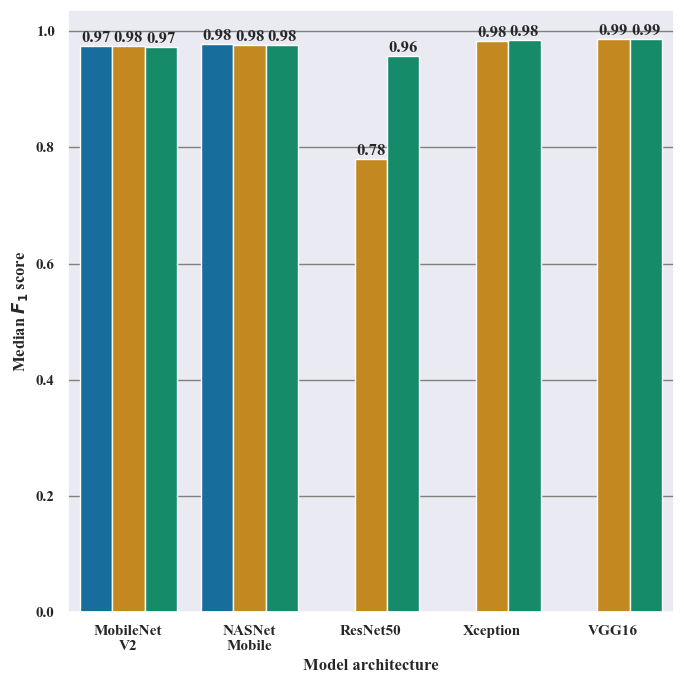

In [48]:
_, ax = barplot(
    analysis_df_no_outliers,
    x="architecture",
    y="f1-score",
    xlabel="Model architecture",
    ylabel="Median $F_1$ score",
    estimator="median",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    barlabel=True,
    figsize=(7, 7),
)

ax.get_legend().remove()
labels = [label.get_text().replace(" ", "\n") for label in ax.get_xticklabels()]
ax.set_xticklabels(labels)

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"accuracy-comparison.{FIGURES_FORMAT}"))

##### $F_1$ score improvement within architectures

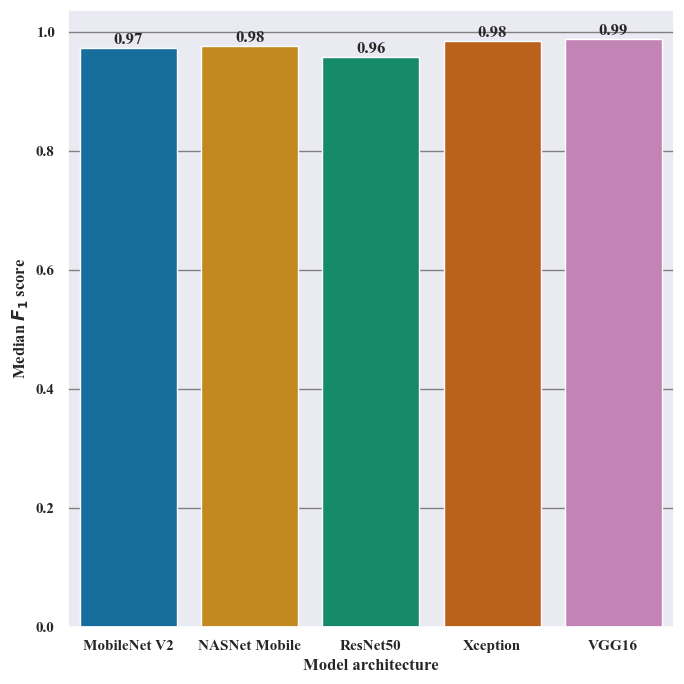

In [49]:
_, ax = barplot(
    analysis_df_no_outliers.query("`training environment` == 'Cloud'"),
    x="architecture",
    y="f1-score",
    xlabel="Model architecture",
    ylabel="Median $F_1$ score",
    estimator="median",
    barlabel=True,
    figname=f"cloud-f1score-comparison.{FIGURES_FORMAT}",
    figsize=(7, 7),
)

In [50]:
improvement = (
    cloud_vgg16_no_energy_outliers["f1-score"].median() - cloud_resnet50_no_gpu_outliers["f1-score"].median()
) / cloud_vgg16_no_energy_outliers["f1-score"].median()
print(f"Maximum improvement: {improvement}")
1 - improvement

Maximum improvement: 0.030557545836576758


0.9694424541634232

In [51]:
improvement = (
    cloud_vgg16_no_energy_outliers["f1-score"].median() - cloud_xception["f1-score"].median()
) / cloud_vgg16_no_energy_outliers["f1-score"].median()
print(f"Minimum improvement: {improvement}")
1 - improvement

Minimum improvement: 0.0025926907201687037


0.9974073092798313

##### Overall $F_1$ score improvement

In [52]:
print_improvement(analysis_df_no_outliers, "f1-score")

Maximum improvement: 0.20913895287181744 (VGG16 - Cloud, ResNet50 - Local ML)
Minimum improvement: 0.00035691008086339204 (NASNet Mobile - Local ML, MobileNet V2 - Local ML)


### Trade-off between accuracy and energy

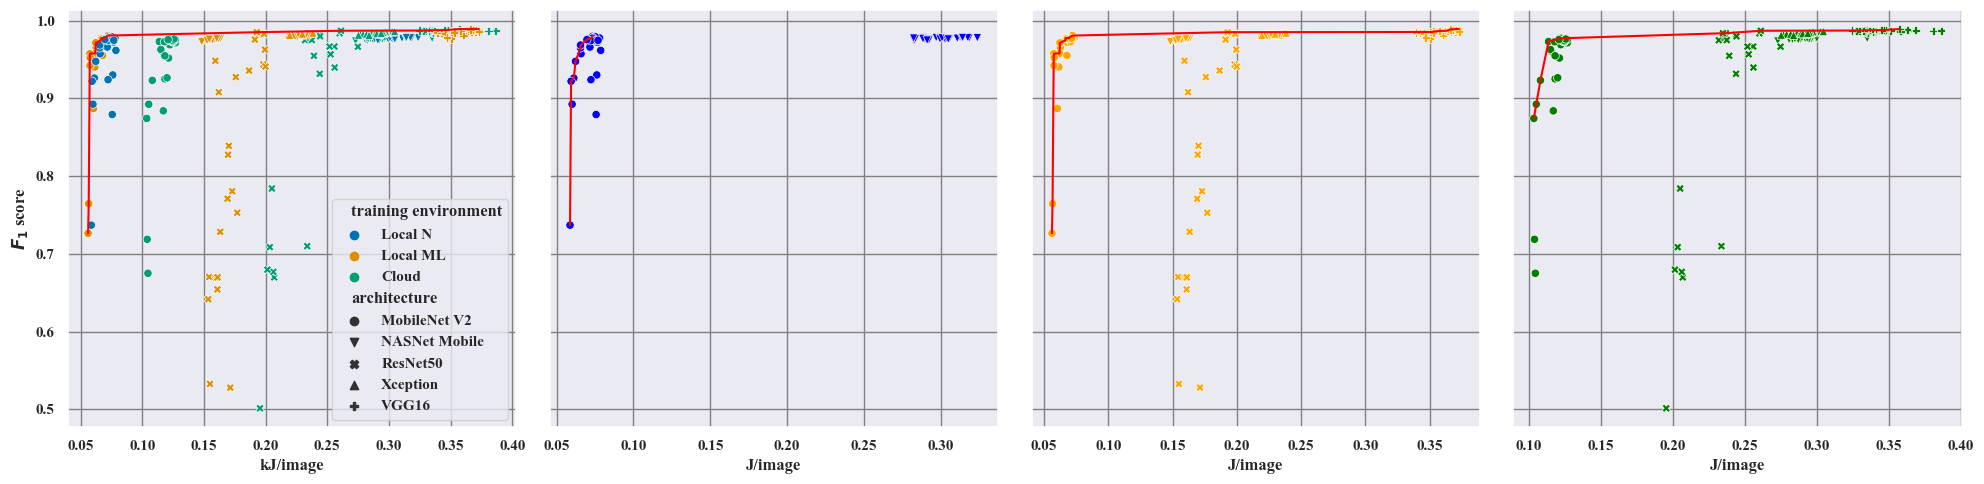

In [53]:
_, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

colors = {"Cloud": "green", "Local N": "blue", "Local ML": "orange"}

tradeoff_data = analysis_df_no_outliers.query("`f1-score` >= 0.5")
costs = tradeoff_data[["energy", "f1-score"]].to_numpy()
pareto = is_pareto_efficient(costs)
sns.scatterplot(
    tradeoff_data,
    x="energy",
    y="f1-score",
    style="architecture",
    markers=MARKERS,
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    ax=axes[0],
)
sns.lineplot(tradeoff_data.loc[pareto], x="energy", y="f1-score", ax=axes[0], color="red")
axes[0].grid(visible=True, axis="both")

axes[0].set_xlabel("kJ/image")
axes[0].set_ylabel("$F_1$ score")

for i, strategy in enumerate(TRAIN_STRATEGIES, 1):
    data = tradeoff_data.query("`training environment` == @strategy")
    costs = data[["energy", "f1-score"]].to_numpy()
    pareto = is_pareto_efficient(costs)
    sns.scatterplot(
        data,
        x="energy",
        y="f1-score",
        style="architecture",
        markers=MARKERS,
        color=colors[strategy],
        ax=axes[i],
    )
    sns.lineplot(data.loc[pareto], x="energy", y="f1-score", ax=axes[i], color="red")

    axes[i].get_legend().remove()
    axes[i].set_xlabel("J/image")

    axes[i].grid(visible=True, axis="both")


if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"accuracy-energy-comparison.{FIGURES_FORMAT}"))

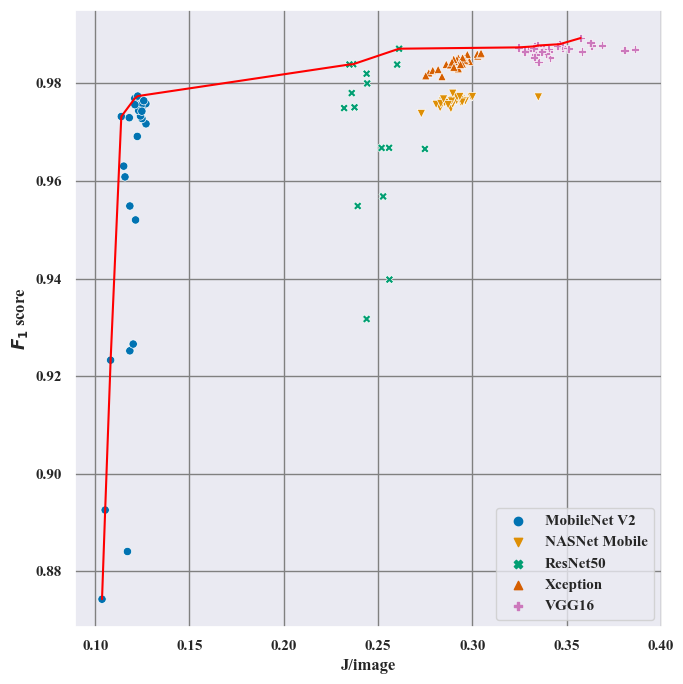

In [54]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))

colors = {"Cloud": "green", "Local N": "blue", "Local ML": "orange"}

tradeoff_data = analysis_df_no_outliers.query("`training environment` == 'Cloud' & `f1-score` >= 0.8")
costs = tradeoff_data[["energy", "f1-score"]].to_numpy()
pareto = is_pareto_efficient(costs)
sns.scatterplot(
    tradeoff_data,
    x="energy",
    y="f1-score",
    style="architecture",
    markers=MARKERS,
    hue="architecture",
    ax=ax,
)
ax.grid(visible=True, axis="both")

ax.set_xlabel("J/image")
ax.set_ylabel("$F_1$ score")

sns.lineplot(tradeoff_data.loc[pareto], x="energy", y="f1-score", ax=ax, color="red")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"accuracy-energy-cloud-comparison.{FIGURES_FORMAT}"))

#### Correlation between $F_1$ score and energy
Looking at the Spearman $\rho$ correlation coefficient, we observe that there is a strong positive correlation between $F_1$ score and energy consumption.

In [55]:
results_df = pd.DataFrame(columns=["training environment", "rho", "p-value"])

for strategy in TRAIN_STRATEGIES:
    data = analysis_df_no_outliers.query("`training environment` == @strategy")
    if not data.empty:
        # print(strategy, architecture)
        corr = stats.spearmanr(data.energy, data["f1-score"], alternative="greater")
        # print(corr)
        # print()
        results_df.loc[len(results_df)] = [strategy, corr[0], corr[1]]
results_df

,training environment,rho,p-value
0,Local N,0.663795,3.714742e-09
1,Local ML,0.758752,7.810593e-30
2,Cloud,0.849561,9.684848e-41


### Energy vs. GPU usage

In [56]:
cloud_energy_vs_gpu_usage_df = pd.concat(
    [
        cloud_mobilenet,
        cloud_nasnet_no_gpu_outliers,
        cloud_xception,
        cloud_resnet50_no_gpu_outliers,
        cloud_vgg16_no_energy_outliers,
    ]
)
local_n_energy_vs_gpu_usage_df = pd.concat(
    [
        local_n_mobilenet,
        local_n_nasnet,
    ]
)

local_ml_energy_vs_gpu_usage_df = pd.concat(
    [
        local_ml_mobilenet_no_gpu_outliers,
        local_ml_nasnet,
        local_ml_xception,
        local_ml_resnet50,
        local_ml_vgg16,
    ]
)

From a general perspective, we do not observe a clear correlation between energy consumption and GPU usage.

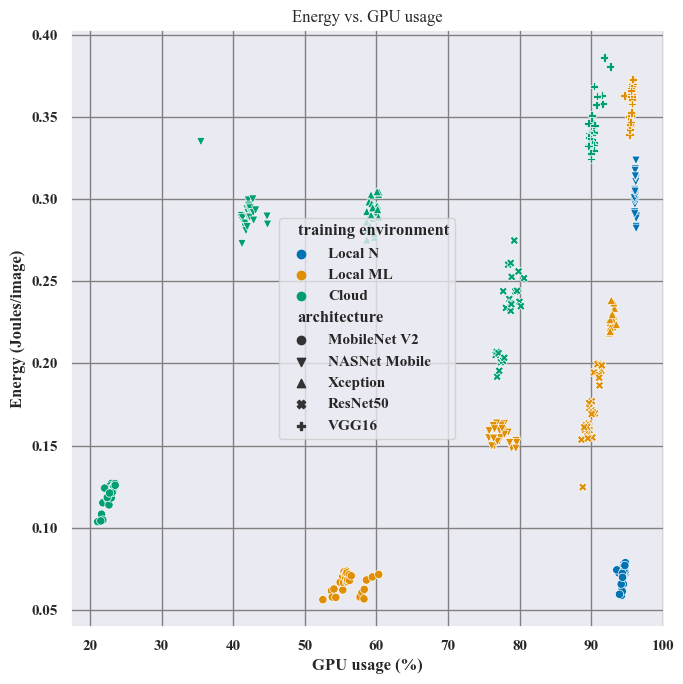

In [57]:
energy_vs_gpu_usage_df = pd.concat(
    [local_n_energy_vs_gpu_usage_df, local_ml_energy_vs_gpu_usage_df, cloud_energy_vs_gpu_usage_df]
)

_, axis = plt.subplots(1, 1, figsize=((7, 7)))
ax = sns.scatterplot(
    energy_vs_gpu_usage_df,
    y="energy",
    x="gpu_usage",
    ax=axis,
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    style="architecture",
    markers=MARKERS,
    legend="brief",
)
ax.set_title("Energy vs. GPU usage")
ax.set_ylabel("Energy (Joules/image)")
ax.set_xlabel("GPU usage (%)")
plt.show()

#### Correlation between energy and GPU usage

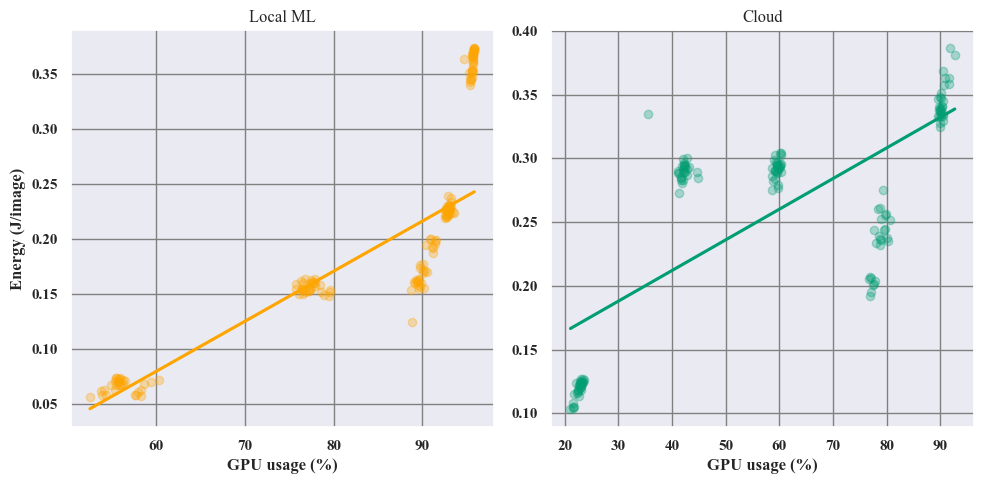

In [58]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
tmp = local_ml_energy_vs_gpu_usage_df.copy()
tmp.energy = local_ml_energy_vs_gpu_usage_df.energy.apply(np.log)
ax = sns.regplot(
    local_ml_energy_vs_gpu_usage_df,
    y="energy",
    x="gpu_usage",
    ax=ax0,
    color=COLORS["Local ML"],
    ci=None,
    robust=True,
    scatter_kws={"alpha": 0.3},
)
ax.set_title("Local ML")
ax.set_ylabel("Energy (J/image)")
ax.set_xlabel("GPU usage (%)")

tmp = cloud_energy_vs_gpu_usage_df.copy()
tmp.energy = cloud_energy_vs_gpu_usage_df.energy.apply(np.log)
ax = sns.regplot(
    cloud_energy_vs_gpu_usage_df,
    y="energy",
    x="gpu_usage",
    ax=ax1,
    color=COLORS["Cloud"],
    ci=None,
    robust=True,
    scatter_kws={"alpha": 0.3},
)
ax.set_title("Cloud")
ax.set_ylabel(None)
ax.set_xlabel("GPU usage (%)")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"energy-gpu-regression.{FIGURES_FORMAT}"))

In [59]:
stats.spearmanr(
    local_ml_energy_vs_gpu_usage_df.energy,
    local_ml_energy_vs_gpu_usage_df.gpu_usage,
    alternative="greater",
)

SignificanceResult(statistic=0.9669899329547085, pvalue=2.8851025643012e-91)

In [60]:
stats.spearmanr(
    cloud_energy_vs_gpu_usage_df.energy,
    cloud_energy_vs_gpu_usage_df.gpu_usage,
    alternative="greater",
)

SignificanceResult(statistic=0.6930305235669334, pvalue=8.509728624528388e-22)

## Statistical significance analysis

### RQ1 - What is the impact of model architecture on a computer vision system with respect to energy efficiency and model correctness?

In [61]:
rq1_df = pd.concat(
    [
        cloud_mobilenet,
        cloud_nasnet_no_gpu_outliers,
        cloud_xception,
        cloud_resnet50_no_gpu_outliers.query("`f1-score` > 0"),
        cloud_vgg16_no_energy_outliers,
    ]
)
rq1_df.energy = rq1_df.energy.apply(np.sqrt)

#### RQ1.1 - How do DL architectures compare in terms of energy efficiency?

##### Energy
First we test the assumption of normality and homogeneity of the data. After applying a square root transformation to the energy data, we observe that the data is normally distributed. However, the data is not homogenous. Although the Shapiro-Wilk test indicates that the VGG16 data is not normally distributed, seeing the Q-Q plot we consider that the assumption of normality is met. Therefore, we perform a Welch's ANOVA test.

Shapiro test for normality of group 0: W = 0.8380956649780273 and p-value 0.00035277512506581843
Shapiro test for normality of group 1: W = 0.7553832530975342 and p-value 2.5323364752694033e-05
Shapiro test for normality of group 2: W = 0.9558075666427612 and p-value 0.2411566525697708
Shapiro test for normality of group 3: W = 0.9173876643180847 and p-value 0.04468826949596405
Shapiro test for normality of group 4: W = 0.897458016872406 and p-value 0.0085202157497406
Levene test for equal variances: W = 10.12738682472641 and p-value = 3.3164941519940583e-07


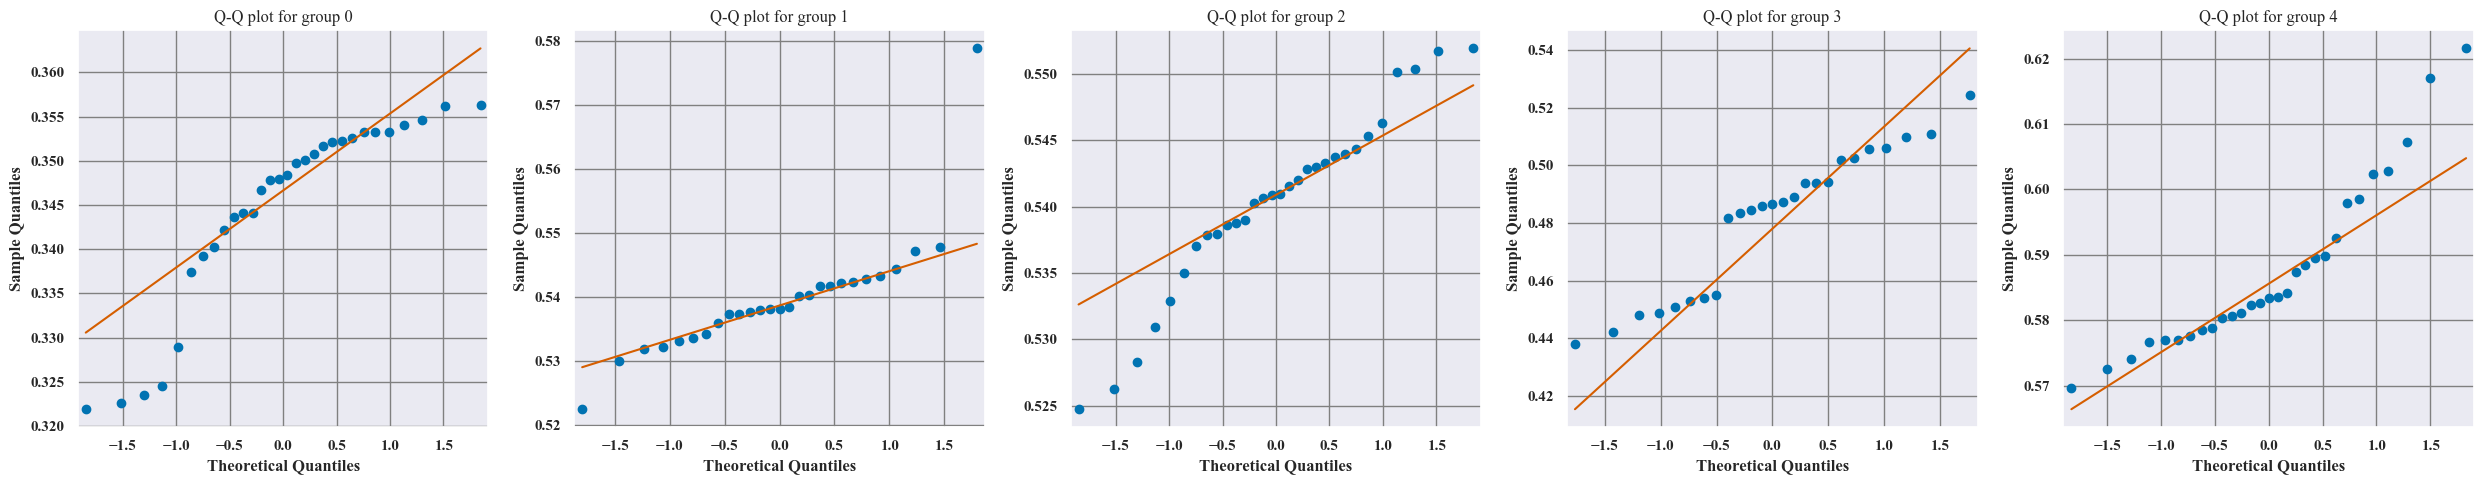

In [62]:
dependent_variable = "energy"
independent_variable = "architecture"

test_assumptions(
    rq1_df.query("architecture == 'MobileNet V2'")[dependent_variable],
    rq1_df.query("architecture == 'NASNet Mobile'")[dependent_variable],
    rq1_df.query("architecture == 'Xception'")[dependent_variable],
    rq1_df.query("architecture == 'ResNet50'")[dependent_variable],
    rq1_df.query("architecture == 'VGG16'")[dependent_variable],
    nrows=1,
    ncols=5,
    figsize=(25, 5),
)

###### Welch's ANOVA test

In [63]:
pg.welch_anova(rq1_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,architecture,4,64.572661,2232.208845,2.001494e-68,0.975059


###### Games-Howell post-hoc test

In [64]:
pg.pairwise_gameshowell(rq1_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,MobileNet V2,NASNet Mobile,0.344784,0.539676,-0.194892,0.002668,-73.041122,54.998550,0.000000e+00,-19.006551
1,MobileNet V2,ResNet50,0.344784,0.481329,-0.136545,0.005361,-25.471855,31.132968,0.000000e+00,-7.253680
2,MobileNet V2,VGG16,0.344784,0.587427,-0.242643,0.003084,-78.671701,54.084963,0.000000e+00,-20.285832
3,MobileNet V2,Xception,0.344784,0.540359,-0.195575,0.002308,-84.746225,49.901140,0.000000e+00,-21.597207
4,NASNet Mobile,ResNet50,0.539676,0.481329,0.058347,0.005328,10.951619,30.422078,4.352296e-11,3.082718
5,NASNet Mobile,VGG16,0.539676,0.587427,-0.047751,0.003027,-15.776800,51.412394,0.000000e+00,-4.116068
6,NASNet Mobile,Xception,0.539676,0.540359,-0.000683,0.002230,-0.306356,46.893153,9.980153e-01,-0.081516
7,ResNet50,VGG16,0.481329,0.587427,-0.106098,0.005548,-19.124568,34.781052,0.000000e+00,-5.373208
8,ResNet50,Xception,0.481329,0.540359,-0.059030,0.005157,-11.447473,27.059468,6.854495e-11,-3.309685
9,VGG16,Xception,0.587427,0.540359,0.047068,0.002714,17.341216,42.431754,0.000000e+00,4.499237


###### Kruskal-Wallis test

In [65]:
result_rq11 = pg.kruskal(rq1_df, dv=dependent_variable, between=independent_variable)
result_rq11

,Source,ddof1,H,p-unc
Kruskal,architecture,4,127.183848,1.557961e-26


###### Eta-squared measure

In [66]:
eta_squared(result_rq11["H"].item(), rq1_df[independent_variable].nunique(), rq1_df.shape[0])

0.9057635891706861

###### Dunn's test

In [67]:
p_values = sp.posthoc_dunn(
    rq1_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm", sort=True
)

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,MobileNet V2,NASNet Mobile,ResNet50,VGG16,Xception
MobileNet V2,False,True,True,True,True
NASNet Mobile,True,False,True,True,False
ResNet50,True,True,False,True,True
VGG16,True,True,True,False,True
Xception,True,False,True,True,False


In [68]:
mobilenet_v2 = rq1_df[dependent_variable][rq1_df["architecture"] == "MobileNet V2"]
nasnet_mobile = rq1_df[dependent_variable][rq1_df["architecture"] == "NASNet Mobile"]
xception = rq1_df[dependent_variable][rq1_df["architecture"] == "Xception"]
resnet50 = rq1_df[dependent_variable][rq1_df["architecture"] == "ResNet50"]
vgg16 = rq1_df[dependent_variable][rq1_df["architecture"] == "VGG16"]

print(f"MobileNet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}")
print(f"MobileNet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"MobileNet V2 - ResNet50 effect size: {cliffs_delta(mobilenet_v2, resnet50)}")
print(f"MobileNet V2 - VGG16 effect size: {cliffs_delta(mobilenet_v2, vgg16)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")
print(f"NASNet Mobile - ResNet50 effect size: {cliffs_delta(nasnet_mobile, resnet50)}")
print(f"NASNet Mobile - VGG16 effect size: {cliffs_delta(nasnet_mobile, vgg16)}")
print(f"Xception - ResNet50 effect size: {cliffs_delta(xception, resnet50)}")
print(f"Xception - VGG16 effect size: {cliffs_delta(xception, vgg16)}")
print(f"ResNet50 - VGG16 effect size: {cliffs_delta(resnet50, vgg16)}")

MobileNet V2 - NASNet Mobile effect size: (-1.0, 'large')
MobileNet V2 - Xception effect size: (-1.0, 'large')
MobileNet V2 - ResNet50 effect size: (-1.0, 'large')
MobileNet V2 - VGG16 effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (-0.1925925925925926, 'small')
NASNet Mobile - ResNet50 effect size: (0.997037037037037, 'large')
NASNet Mobile - VGG16 effect size: (-0.979565772669221, 'large')
Xception - ResNet50 effect size: (1.0, 'large')
Xception - VGG16 effect size: (-1.0, 'large')
ResNet50 - VGG16 effect size: (-1.0, 'large')


##### GPU usage
In this case, we observe that the data is not normally distributed. Therefore, we take the results from the Kruskal-Wallis test as the relevant ones.

Shapiro test for normality of group 0: W = 0.9209879040718079 and p-value 0.028453435748815536
Shapiro test for normality of group 1: W = 0.6963743567466736 and p-value 3.4535089525888907e-06
Shapiro test for normality of group 2: W = 0.9507325291633606 and p-value 0.17686785757541656
Shapiro test for normality of group 3: W = 0.9611562490463257 and p-value 0.43798255920410156
Shapiro test for normality of group 4: W = 0.8111292719841003 and p-value 0.00013311690418049693
Levene test for equal variances: W = 2.6598437994252793 and p-value = 0.03539418063940629


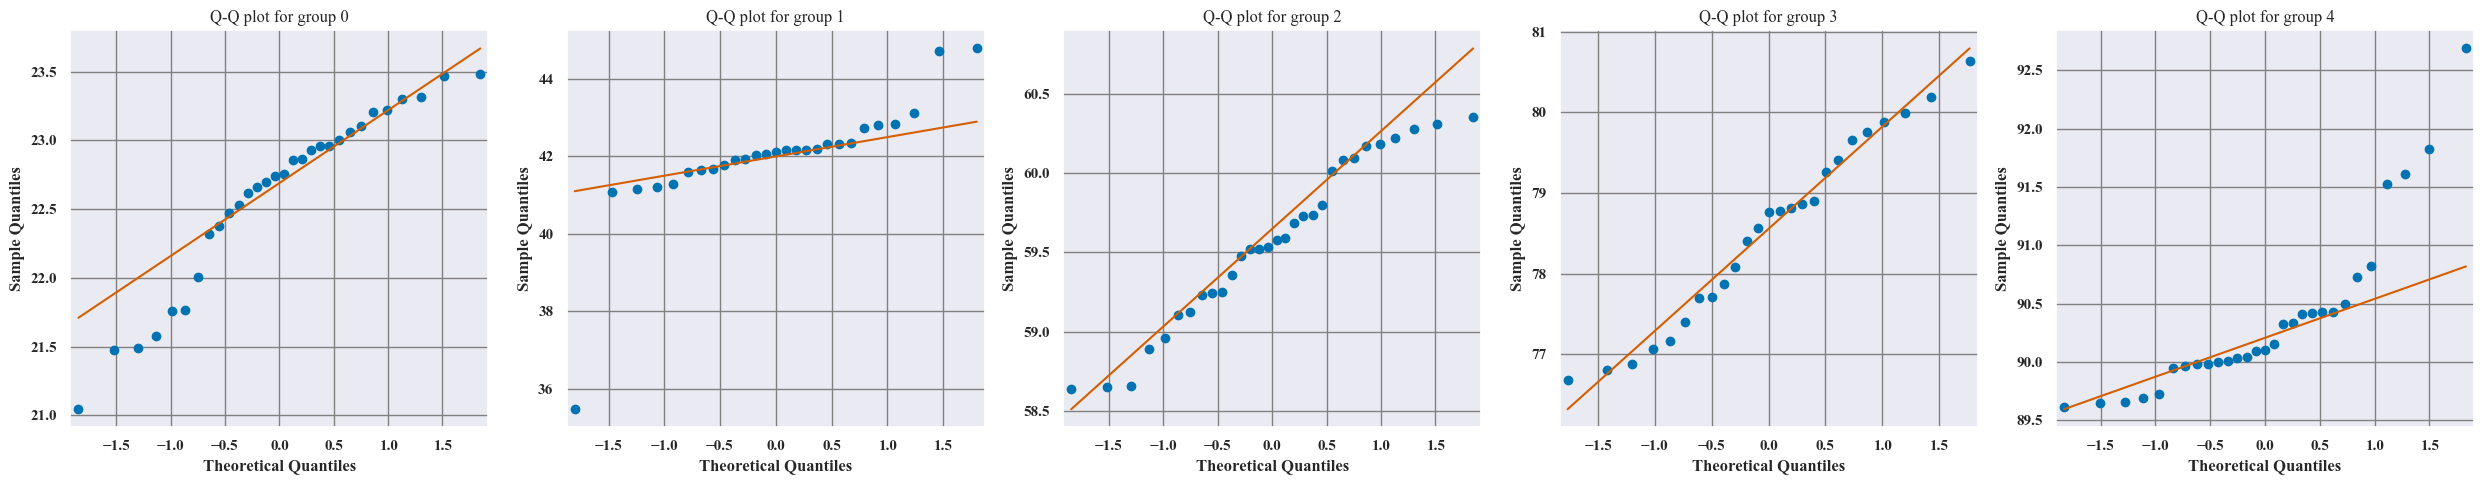

In [69]:
dependent_variable = "gpu_usage"

test_assumptions(
    rq1_df.query("architecture == 'MobileNet V2'")[dependent_variable],
    rq1_df.query("architecture == 'NASNet Mobile'")[dependent_variable],
    rq1_df.query("architecture == 'Xception'")[dependent_variable],
    rq1_df.query("architecture == 'ResNet50'")[dependent_variable],
    rq1_df.query("architecture == 'VGG16'")[dependent_variable],
    nrows=1,
    ncols=5,
    figsize=(25, 5),
)

###### Welch's ANOVA test

In [70]:
pg.welch_anova(rq1_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,architecture,4,64.403011,38132.455579,7.124445e-108,0.998466


###### Games-Howell post-hoc test

In [71]:
pg.pairwise_gameshowell(rq1_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,MobileNet V2,NASNet Mobile,22.601064,41.979014,-19.377950,0.325718,-59.493096,33.936603,2.442491e-15,-16.167298
1,MobileNet V2,ResNet50,22.601064,78.530723,-55.929658,0.260412,-214.773610,36.300415,4.440892e-16,-60.152857
2,MobileNet V2,VGG16,22.601064,90.369925,-67.768860,0.179230,-378.111412,56.012035,0.000000e+00,-97.329846
3,MobileNet V2,Xception,22.601064,59.566237,-36.965173,0.152265,-242.769109,55.184596,1.443290e-15,-61.868653
4,NASNet Mobile,ResNet50,41.979014,78.530723,-36.551709,0.381425,-95.829296,47.625652,0.000000e+00,-25.891996
5,NASNet Mobile,VGG16,41.979014,90.369925,-48.390911,0.331352,-146.040868,35.860243,0.000000e+00,-39.438340
6,NASNet Mobile,Xception,41.979014,59.566237,-17.587223,0.317577,-55.379372,31.061133,7.771561e-16,-15.128473
7,ResNet50,VGG16,78.530723,90.369925,-11.839202,0.267426,-44.270978,38.988323,0.000000e+00,-12.310932
8,ResNet50,Xception,78.530723,59.566237,18.964486,0.250155,75.810797,31.966943,0.000000e+00,21.527565
9,VGG16,Xception,90.369925,59.566237,30.803688,0.163971,187.860129,50.777594,1.332268e-15,48.540027


###### Kruskal-Wallis test

In [72]:
result_rq11 = pg.kruskal(rq1_df, dv=dependent_variable, between=independent_variable)
result_rq11

,Source,ddof1,H,p-unc
Kruskal,architecture,4,134.328439,4.618560e-28


###### Eta-squared measure

In [73]:
eta_squared(result_rq11["H"].item(), rq1_df[independent_variable].nunique(), rq1_df.shape[0])

0.9582973435103743

###### Dunn's test

In [74]:
p_values = sp.posthoc_dunn(
    rq1_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm", sort=True
)

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,MobileNet V2,NASNet Mobile,ResNet50,VGG16,Xception
MobileNet V2,False,True,True,True,True
NASNet Mobile,True,False,True,True,True
ResNet50,True,True,False,True,True
VGG16,True,True,True,False,True
Xception,True,True,True,True,False


In [75]:
mobilenet_v2 = rq1_df[dependent_variable][rq1_df["architecture"] == "MobileNet V2"]
nasnet_mobile = rq1_df[dependent_variable][rq1_df["architecture"] == "NASNet Mobile"]
xception = rq1_df[dependent_variable][rq1_df["architecture"] == "Xception"]
resnet50 = rq1_df[dependent_variable][rq1_df["architecture"] == "ResNet50"]
vgg16 = rq1_df[dependent_variable][rq1_df["architecture"] == "VGG16"]

print(f"MobileNet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}")
print(f"MobileNet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"MobileNet V2 - ResNet50 effect size: {cliffs_delta(mobilenet_v2, resnet50)}")
print(f"MobileNet V2 - VGG16 effect size: {cliffs_delta(mobilenet_v2, vgg16)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")
print(f"NASNet Mobile - ResNet50 effect size: {cliffs_delta(nasnet_mobile, resnet50)}")
print(f"NASNet Mobile - VGG16 effect size: {cliffs_delta(nasnet_mobile, vgg16)}")
print(f"Xception - ResNet50 effect size: {cliffs_delta(xception, resnet50)}")
print(f"Xception - VGG16 effect size: {cliffs_delta(xception, vgg16)}")
print(f"ResNet50 - VGG16 effect size: {cliffs_delta(resnet50, vgg16)}")

MobileNet V2 - NASNet Mobile effect size: (-1.0, 'large')
MobileNet V2 - Xception effect size: (-1.0, 'large')
MobileNet V2 - ResNet50 effect size: (-1.0, 'large')
MobileNet V2 - VGG16 effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (-1.0, 'large')
NASNet Mobile - ResNet50 effect size: (-1.0, 'large')
NASNet Mobile - VGG16 effect size: (-1.0, 'large')
Xception - ResNet50 effect size: (-1.0, 'large')
Xception - VGG16 effect size: (-1.0, 'large')
ResNet50 - VGG16 effect size: (-1.0, 'large')


#### RQ1.2 - Do gains in correctness achieved by energy-greedy architectures justify their increased energy consumption?

As we clearly see from the Q-Q plots, the F1-score data is not normally distributed. Therefore, we perform a Kruskal-Wallis test.

Shapiro test for normality of group 0: W = 0.5614897012710571 and p-value 2.5521618596258122e-08
Shapiro test for normality of group 1: W = 0.9547452330589294 and p-value 0.27878597378730774
Shapiro test for normality of group 2: W = 0.9610384106636047 and p-value 0.3292081356048584
Shapiro test for normality of group 3: W = 0.6999666094779968 and p-value 7.28050463294494e-06
Shapiro test for normality of group 4: W = 0.9783178567886353 and p-value 0.7939429879188538
Levene test for equal variances: W = 10.80890057689575 and p-value = 1.2258055228547797e-07


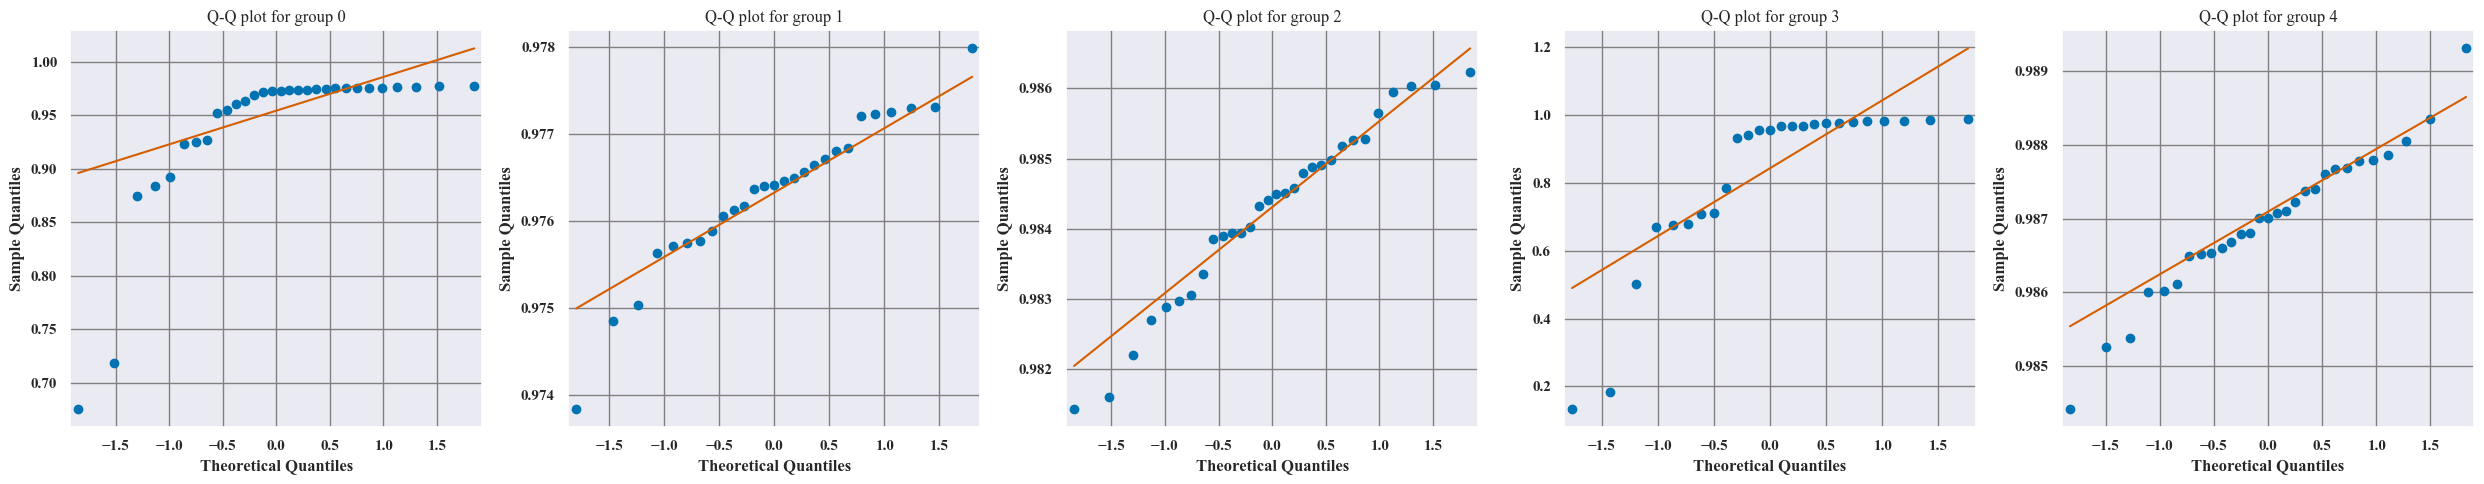

In [76]:
dependent_variable = "f1-score"

test_assumptions(
    rq1_df.query("architecture == 'MobileNet V2'")[dependent_variable],
    rq1_df.query("architecture == 'NASNet Mobile'")[dependent_variable],
    rq1_df.query("architecture == 'Xception'")[dependent_variable],
    rq1_df.query("architecture == 'ResNet50'")[dependent_variable],
    rq1_df.query("architecture == 'VGG16'")[dependent_variable],
    nrows=1,
    ncols=5,
    figsize=(25, 5),
)

##### Kruskal-Wallis test

In [77]:
result_rq12 = pg.kruskal(rq1_df, dv=dependent_variable, between=independent_variable)
result_rq12

,Source,ddof1,H,p-unc
Kruskal,architecture,4,109.077387,1.144833e-22


##### Eta-squared measure

In [78]:
eta_squared(result_rq12["H"].item(), rq1_df[independent_variable].nunique(), rq1_df.shape[0])

0.7726278466306167

##### Dunn's test

In [79]:
p_values = sp.posthoc_dunn(rq1_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,MobileNet V2,NASNet Mobile,ResNet50,VGG16,Xception
MobileNet V2,False,False,False,True,True
NASNet Mobile,False,False,False,True,True
ResNet50,False,False,False,True,True
VGG16,True,True,True,False,True
Xception,True,True,True,True,False


In [80]:
mobilenet_v2 = rq1_df[dependent_variable][rq1_df["architecture"] == "MobileNet V2"]
nasnet_mobile = rq1_df[dependent_variable][rq1_df["architecture"] == "NASNet Mobile"]
xception = rq1_df[dependent_variable][rq1_df["architecture"] == "Xception"]
resnet50 = rq1_df[dependent_variable][rq1_df["architecture"] == "ResNet50"]
vgg16 = rq1_df[dependent_variable][rq1_df["architecture"] == "VGG16"]

print(f"MobileNet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}")
print(f"MobileNet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"MobileNet V2 - ResNet50 effect size: {cliffs_delta(mobilenet_v2, resnet50)}")
print(f"MobileNet V2 - VGG16 effect size: {cliffs_delta(mobilenet_v2, vgg16)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")
print(f"NASNet Mobile - ResNet50 effect size: {cliffs_delta(nasnet_mobile, resnet50)}")
print(f"NASNet Mobile - VGG16 effect size: {cliffs_delta(nasnet_mobile, vgg16)}")
print(f"Xception - ResNet50 effect size: {cliffs_delta(xception, resnet50)}")
print(f"Xception - VGG16 effect size: {cliffs_delta(xception, vgg16)}")
print(f"ResNet50 - VGG16 effect size: {cliffs_delta(resnet50, vgg16)}")

MobileNet V2 - NASNet Mobile effect size: (-0.7604938271604939, 'large')
MobileNet V2 - Xception effect size: (-1.0, 'large')
MobileNet V2 - ResNet50 effect size: (0.12, 'negligible')
MobileNet V2 - VGG16 effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (-1.0, 'large')
NASNet Mobile - ResNet50 effect size: (0.42518518518518517, 'medium')
NASNet Mobile - VGG16 effect size: (-1.0, 'large')
Xception - ResNet50 effect size: (0.8346666666666667, 'large')
Xception - VGG16 effect size: (-0.9229885057471264, 'large')
ResNet50 - VGG16 effect size: (-0.953103448275862, 'large')


### RQ1.3 - How does the complexity of a DL architecture affect energy efficiency?

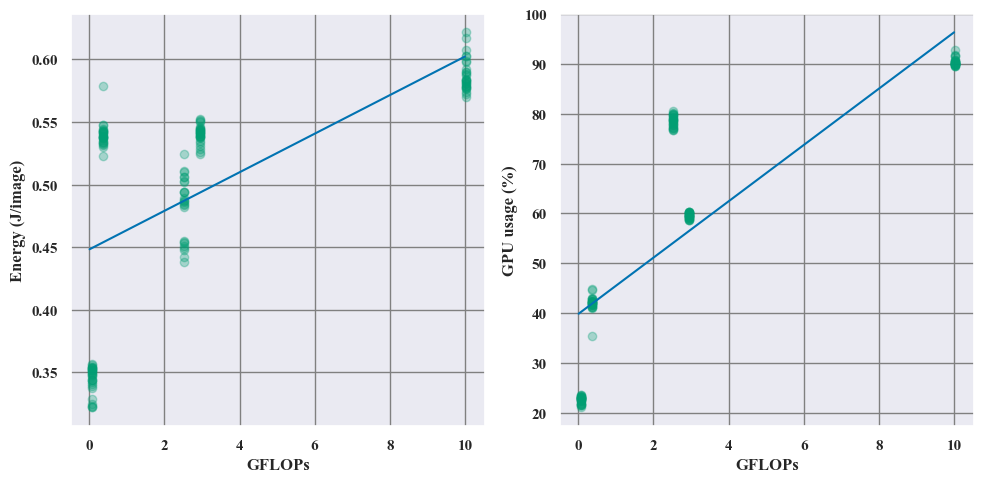

In [81]:
grouped_df = (
    analysis_df_no_outliers.query("`training environment` != 'Local N'")
    .groupby(["training environment", "architecture"], as_index=False)
    .agg(GFLOPs=("GFLOPs", "first"), energy=("energy", "median"), gpu_usage=("gpu_usage", "median"))
)

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

x = rq1_df.GFLOPs
y = rq1_df.energy

ax0.scatter(
    x,
    y,
    color=COLORS["Cloud"],
    alpha=0.3,
)

m, b = np.polyfit(x, y, 1)
samples = np.linspace(1e-2, 10, 100)
ax0.plot(samples, m * samples + b, color="b")

ax0.set_ylabel("Energy (J/image)")
ax0.set_xlabel("GFLOPs")

y = rq1_df.gpu_usage

ax1.scatter(
    x,
    y,
    color=COLORS["Cloud"],
    alpha=0.3,
)

ax1.set_ylabel("GPU usage (%)")
ax1.set_xlabel("GFLOPs")

# p1, p2 = np.polyfit(np.log(x), y, 1)
# ax1.plot(samples, p1 * np.log(samples) + p2, "r", label="logarithmic reg")

m, b = np.polyfit(x, y, 1)
ax1.plot(samples, m * samples + b, color="b", label="linear reg")
# ax1.legend()

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"cloud-energy-flops-regression.{FIGURES_FORMAT}"))

#### Correlation between FLOPs and Energy, and FLOPs and GPU usage

##### Local ML
Energy/FLOPs correlation

In [82]:
stats.spearmanr(
    local_ml_energy_vs_gpu_usage_df.energy,
    local_ml_energy_vs_gpu_usage_df.GFLOPs,
    alternative="greater",
)

SignificanceResult(statistic=0.9651256526128343, pvalue=1.6579745411148263e-89)

GPU usage/FLOPs correlation

In [83]:
stats.spearmanr(
    local_ml_energy_vs_gpu_usage_df.gpu_usage,
    local_ml_energy_vs_gpu_usage_df.GFLOPs,
    alternative="greater",
)

SignificanceResult(statistic=0.9797741338970708, pvalue=5.129837057755373e-107)

##### Cloud
Energy/FLOPs correlation

In [84]:
stats.spearmanr(rq1_df.energy, rq1_df.GFLOPs, alternative="greater")

SignificanceResult(statistic=0.8235865663761329, pvalue=2.397711580717397e-36)

GPU usage/FLOPs correlation

In [85]:
stats.spearmanr(rq1_df.gpu_usage, rq1_df.GFLOPs, alternative="greater")

SignificanceResult(statistic=0.88939456142618, pvalue=2.1164476733732667e-49)

### RQ2 - Are local environments more energy-greedy than cloud environments when training DL models?

In [86]:
rq2_df = pd.concat([local_n_mobilenet, local_ml_mobilenet_no_gpu_outliers, cloud_mobilenet])

#### Energy
The energy data for RQ2 is not normally distributed. Therefore, the relevant results are obtained from the Kruskal-Wallis test.

Shapiro test for normality of group 0: W = 0.8882032632827759 and p-value 0.004374742042273283
Shapiro test for normality of group 1: W = 0.8984531164169312 and p-value 0.007699527777731419
Shapiro test for normality of group 2: W = 0.8453041911125183 and p-value 0.0004952006274834275
Levene test for equal variances: W = 0.43092249339071936 and p-value = 0.6512888263434922


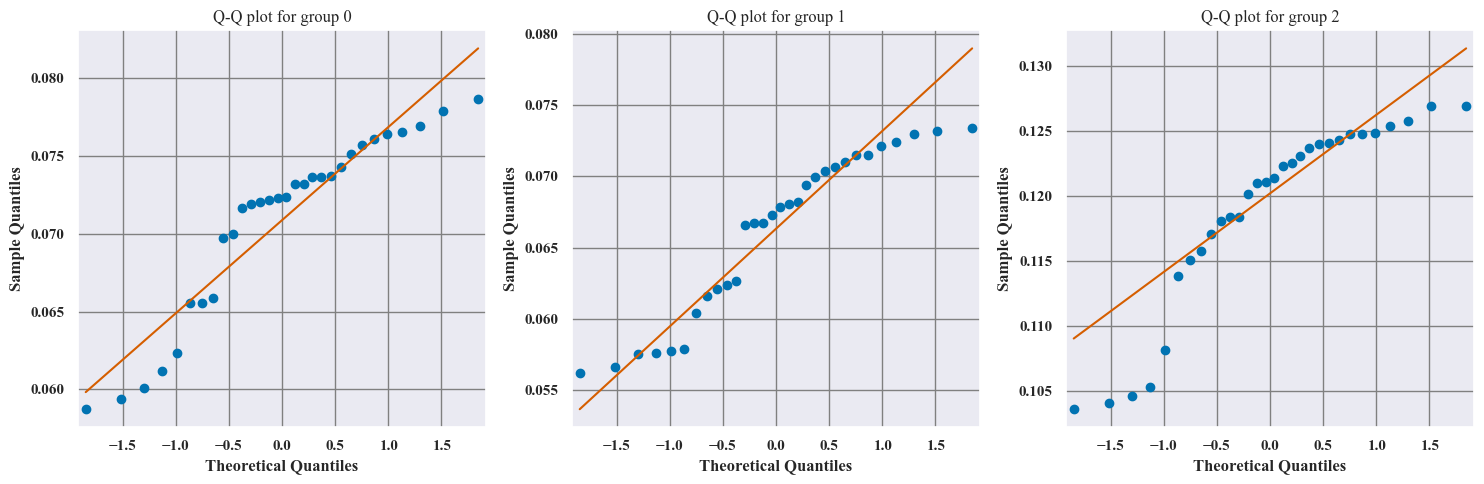

In [87]:
independent_variable = "training environment"
dependent_variable = "energy"

test_assumptions(
    rq2_df.query("`training environment` == 'Local N'")[dependent_variable],
    rq2_df.query("`training environment` == 'Local ML'")[dependent_variable],
    rq2_df.query("`training environment` == 'Cloud'")[dependent_variable],
    nrows=1,
    ncols=3,
    figsize=(15, 5),
)

##### Welch's ANOVA test

In [88]:
pg.welch_anova(rq2_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,training environment,2,57.488736,559.826382,2.037347e-38,0.937361


##### Tukey post-hoc test

In [89]:
pg.pairwise_gameshowell(rq2_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Cloud,Local ML,0.118984,0.066087,0.052898,0.001679,31.505897,55.333804,8.881784e-15,8.029141
1,Cloud,Local N,0.118984,0.070868,0.048117,0.001687,28.526633,55.587206,0.000000e+00,7.269889
2,Local ML,Local N,0.066087,0.070868,-0.004781,0.001492,-3.204493,57.992057,6.140854e-03,-0.816651


##### Kruskal-Wallis test

In [90]:
result_rq21 = pg.kruskal(rq2_df, dv=dependent_variable, between=independent_variable)
result_rq21

,Source,ddof1,H,p-unc
Kruskal,training environment,2,64.285714,1.097829e-14


##### Eta-squared measure

In [91]:
eta_squared(result_rq21["H"].item(), rq2_df[independent_variable].nunique(), rq2_df.shape[0])

0.7159277504105089

##### Dunn's test

In [92]:
p_values = sp.posthoc_dunn(rq2_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,Cloud,Local ML,Local N
Cloud,False,True,True
Local ML,True,False,True
Local N,True,True,False


In [93]:
local = rq2_df[dependent_variable][rq2_df["training environment"] == "Local N"]
local_ml = rq2_df[dependent_variable][rq2_df["training environment"] == "Local ML"]
Cloud = rq2_df[dependent_variable][rq2_df["training environment"] == "Cloud"]

print(f"Local - Local ML effect size: {cliffs_delta(local, local_ml)}")
print(f"Local - Cloud effect size: {cliffs_delta(local, Cloud)}")
print(f"Local ML - Cloud effect size: {cliffs_delta(local_ml, Cloud)}")

Local - Local ML effect size: (0.5, 'large')
Local - Cloud effect size: (-1.0, 'large')
Local ML - Cloud effect size: (-1.0, 'large')


#### GPU usage
As with the energy data, GPU usage data is not normally distributed. Therefore, the relevant results are obtained from the Kruskal-Wallis test.


In [94]:
local = rq2_df.gpu_usage[rq2_df["training environment"] == "Local N"]
local_ml = rq2_df.gpu_usage[rq2_df["training environment"] == "Local ML"]
Cloud = rq2_df.gpu_usage[rq2_df["training environment"] == "Cloud"]

dependent_variable = "gpu_usage"

Shapiro test for normality of group 0: W = 0.9337794780731201 and p-value 0.06192095950245857
Shapiro test for normality of group 1: W = 0.955195963382721 and p-value 0.23238784074783325
Shapiro test for normality of group 2: W = 0.9209879040718079 and p-value 0.028453435748815536
Levene test for equal variances: W = 15.169472968055345 and p-value = 2.2302448531200786e-06


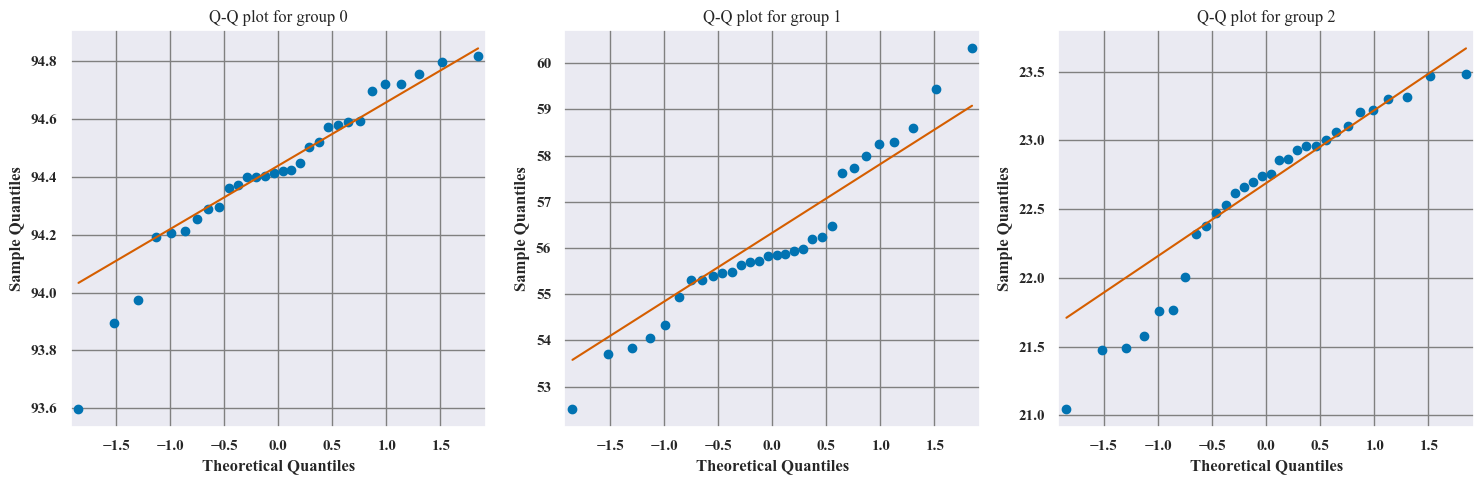

In [95]:
test_assumptions(local, local_ml, Cloud, nrows=1, ncols=3, figsize=(15, 5))

##### Welch's ANOVA test

In [96]:
pg.welch_anova(rq2_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,training environment,2,45.022708,155853.634848,3.530936e-87,0.998665


##### Games-Howell post-hoc test

In [97]:
pg.pairwise_gameshowell(rq2_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Cloud,Local ML,22.601064,56.133512,-33.532447,0.341405,-98.218899,36.900852,0.000000e+00,-25.030660
1,Cloud,Local N,22.601064,94.414385,-71.813321,0.129185,-555.896548,38.815542,3.552714e-15,-141.667821
2,Local ML,Local N,56.133512,94.414385,-38.280874,0.323767,-118.235941,30.403486,9.992007e-16,-30.131916


##### Kruskal-Wallis test

In [98]:
result_rq22 = pg.kruskal(rq2_df, dv=dependent_variable, between=independent_variable)
result_rq22

,Source,ddof1,H,p-unc
Kruskal,training environment,2,79.120879,6.593551e-18


##### Eta-squared measure

In [99]:
eta_squared(result_rq22["H"].item(), rq2_df[independent_variable].nunique(), rq2_df.shape[0])

0.8864468864468865

##### Dunn's test

In [100]:
p_values = sp.posthoc_dunn(rq2_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,Cloud,Local ML,Local N
Cloud,False,True,True
Local ML,True,False,True
Local N,True,True,False


In [101]:
print(f"Local - Local ML effect size: {cliffs_delta(local, local_ml)}")
print(f"Local - Cloud effect size: {cliffs_delta(local, Cloud)}")
print(f"Local ML - Cloud effect size: {cliffs_delta(local_ml, Cloud)}")

Local - Local ML effect size: (1.0, 'large')
Local - Cloud effect size: (1.0, 'large')
Local ML - Cloud effect size: (1.0, 'large')
